# Peroxiredoxin red blood cell model (Benfeitas et al. 2014) sims

This notebook performs analyses described in the 

**Manuscript:**

Modelling the decamerisation cycle of PRDX1 and the inhibition-like effect on its peroxidase activity

**Authors:**

C. Barry, C. Pillay, J. Rohwer

**Purpose:**

Reproduce the simulations of Benfeitas et al. 2014 with and without decamerisation

Plots: figure 6, S3, S4, S5, and S6

**Requirements:**

Python libraries (see **Imports** below)

RBC PRDX2-model A of Benfeitas et al 2014 (filename:`RBC_PRDX2_modelA.psc`)

RBC PRDX2 with inhibition-model B of Benfeitas et al 2014 (filename:`RBC_PRDX2_modelB.psc`)

RBC PRDX2-model A with decamerisation (filename:`RBC_PRDX2_modelA_decfull.psc`)

Prx model parameters (filename: `fitted_koff_kon_PRDX1_params.csv`)

Several .pngs from Benfeitas et al. 2014

##### Imports

In [1]:
import os
from IPython.core.display import Image, display 
import math
from math import e

import scipy as sp
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import pandas as pd
from sklearn.metrics import auc

import pysces


/tmp/ipykernel_94435/2988894308.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


Matplotlib backend set to: "nbAgg"
Matplotlib interface loaded (pysces.plt.m)
Pitcon routines available
NLEQ2 routines available
SBML support available
You are using NumPy (1.23.5) with SciPy (1.9.3)
Assimulo CVode available
RateChar is available
Parallel scanner is available

PySCeS environment
******************
pysces.model_dir = /home/chris/Pysces/psc
pysces.output_dir = /home/chris/Pysces


***********************************************************************
* Welcome to PySCeS (1.0.3) - Python Simulator for Cellular Systems   *
*                http://pysces.sourceforge.net                        *
* Copyright(C) B.G. Olivier, J.M. Rohwer, J.-H.S. Hofmeyr, 2004-2022  *
* Triple-J Group for Molecular Cell Physiology                        *
* Stellenbosch University, ZA and VU University Amsterdam, NL         *
* PySCeS is distributed under the PySCeS (BSD style) licence, see     *
* LICENCE.txt (supplied with this release) for details                *
* Please cite PySCeS with

##### Save directories

In [2]:
prev_dir = os.path.split(os.getcwd())[0]

mod_dir = os.path.join(prev_dir,"models")
if not os.path.isdir(mod_dir): os.mkdir(mod_dir) # ensure dir exists

par_dir = os.path.join(prev_dir,"params")
if not os.path.isdir(par_dir): os.mkdir(par_dir) # ensure dir exists
    
fig_dir = os.path.join(os.getcwd(),"Figures")
if not os.path.isdir(fig_dir): os.mkdir(fig_dir) # ensure dir exists


##### Matplotlib stuff

In [3]:
%matplotlib inline

mpl_width = 4.5
mpl_height = 3.5
mpl_dpi = 600
mpl_xlabel_fontsize = "large"
mpl_ylabel_fontsize = "large"
mu = "\u03bc"

mpl_width_squarefig = 3.0
mpl_height_squarefig = 3.0

# Assign line styles for figs 4-7
mod_A_line = "b-"
mod_B_line = "k-"
mod_A_dec_nohyp_line  = "m--"

##### params

In [4]:
df_onestep_params = pd.read_csv(os.path.join(par_dir,"fitted_koff_kon_PRDX1_params.csv"))
df_onestep_params.set_index("Parameter",inplace=True)

In [5]:
def update_params_BenfeitasModels(mod,params,hyp=False):
    """
    Updates the parameters of a model which has been augmented with Prx decamer reactions.
    Adding the decamer reactions introduces several new parameter names which need to be populated with their 
    corrosponding values in the original model as well as the fitted dimer-decamer transition koff and kon.
    As a special case: The decamer sulfenilation rate is set to the original model dimer sulfenilation rate 
    (i.e full activity) and the dimer sulfenilation rate is set to 100-fold less than the original model.
    """
    # Dimer-decamer transition params
    mod.exponent = 5
    mod.k_Prx_asso = params.loc["kon"][0]
    mod.k_Prx_dec_disasso = params.loc["koff"][0]
    
    ## Prx oxidation params
    mod.k_Prx_sulfe_SH_dec = mod.kprx
    mod.k_Prx_sulfe_SOH_dec = mod.kprx
    mod.k_Prx_disulf_form_SH_dec = mod.kcond
    mod.k_Prx_disulf_form_SOH_dec = mod.kcond
    mod.k_Prx_disso_SH_dec = 10000 # Arbitrary 
    mod.k_Prx_disso_SOH_dec = 10000 # Arbitrary
    
    if hyp == True:
        mod.k_Prx_sulfe_SOOH_dec = mod.kprx
        mod.k_Prx_sulfi_SOOH_dec = mod.ksulf
        mod.k_Prx_disulf_form_SOOH_dec = mod.kcond
        mod.k_Prx_srx_SOOH_dec = mod.ksrx 
        mod.k_Prx_disso_SOOH_dec = 10000 # Arbitrary
        
    # Adust dimer sulfenilation to be 100 slower than decamer
    mod.kprx = mod.kprx/100
    mod.two_times_kprx = mod.two_times_kprx/100
    
    return mod

## Initiatize models 

### Model A

In [6]:
# Load model
mod_A = pysces.model("RBC_PRDX2_modelA.psc", dir = mod_dir)
mod_A.mode_integrate_all_odes = True # As recommented by pysces
mod_A.SetQuiet()    
mod_A.showModel()

Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/RBC_PRDX2_modelA.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/RBC_PRDX2_modelA.psc
Info: No reagents have been fixed
Info: "fix_eH2O2" has been initialised but does not occur in a rate equation
Info: "unfix_eH2O2" has been initialised but does not occur in a rate equation
Info: "exH2O2_pulse_length" has been initialised but does not occur in a rate equation
Info: "exH2O2_pulse_conc" has been initialised but does not occur in a rate equation
Info: "do_exH2O2_pulse" has been initialised but does not occur in a rate equation
Info: "extH2O2" has been initialised but does not occur in a rate equation
Info: "init_for_kprx" has been initialised but does not occur in a rate equation
Info: "init_for_kcond" 

In [7]:
mod_A_pos_in_conserved = 4 # Used in some calculations below


### Model B

In [8]:
# Load model
mod_B = pysces.model("RBC_PRDX2_modelB.psc", dir = mod_dir)
mod_B.mode_integrate_all_odes = True # As recommented by pysces
mod_B.SetQuiet()
mod_B.showModel()

Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/RBC_PRDX2_modelB.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/RBC_PRDX2_modelB.psc
Info: No reagents have been fixed
Info: "fix_eH2O2" has been initialised but does not occur in a rate equation
Info: "unfix_eH2O2" has been initialised but does not occur in a rate equation
Info: "exH2O2_pulse_length" has been initialised but does not occur in a rate equation
Info: "exH2O2_pulse_conc" has been initialised but does not occur in a rate equation
Info: "do_exH2O2_pulse" has been initialised but does not occur in a rate equation
Info: "extH2O2" has been initialised but does not occur in a rate equation
Info: "init_for_kprx" has been initialised but does not occur in a rate equation
Info: "init_for_kcond" 

In [9]:
mod_B_pos_in_conserved = 2 # Used in some calculations below


### Model A with decamerisation

In [10]:
# Load model
mod_A_dec_nohyp = pysces.model("RBC_PRDX2_modelA_decfull.psc", dir = mod_dir)
mod_A_dec_nohyp.mode_integrate_all_odes = True # As recommented by pysces
mod_A_dec_nohyp.SetQuiet()
mod_A_dec_nohyp = update_params_BenfeitasModels(mod_A_dec_nohyp,df_onestep_params)

Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/RBC_PRDX2_modelA_decfull.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/RBC_PRDX2_modelA_decfull.psc
Info: No reagents have been fixed
Info: "fix_eH2O2" has been initialised but does not occur in a rate equation
Info: "unfix_eH2O2" has been initialised but does not occur in a rate equation
Info: "exH2O2_pulse_length" has been initialised but does not occur in a rate equation
Info: "exH2O2_pulse_conc" has been initialised but does not occur in a rate equation
Info: "do_exH2O2_pulse" has been initialised but does not occur in a rate equation
Info: "extH2O2" has been initialised but does not occur in a rate equation
Info: "init_for_kprx" has been initialised but does not occur in a rate equation
Info: "

In [11]:
mod_A_dec_nohyp_pos_in_conserved = 4 # Used in some calculations below


## Analyses of Benfeitas 2014 figures

Below we reproduce figures 3-7 of Benfeitas et al 2014 in the correspondingly named sections. The text and image of each of the original figures are copied here for reference. 


### Fig 3

Fig. 3. Simulations of responses of Prx2 in intact erythrocytes to H 2 O 2 boluses as per experiments in Ref. [2]. Low et al. [2] exposed human erythrocytes (5  10 9 cells dm  3 ,
pH 7.4, 37 1C, 5 mM glucose) to H 2 O 2 boluses and determined the fractions of Prx2 monomers or disulfide-crosslinked dimers in nonreducing SDS–polyacrylamide gel
electrophoresis gels for the indicated boluses and times. Disulfide Prx2 ran in most cases as a double band, the upper and lower components of which corresponding to
dimers with one and two disulfides, respectively [22]. Comparisons to simulation results must take into account that the experiments overestimate the fraction of oxidized
Prx2, owing to adventitious oxidation during sample handling [2]. To simulate these experiments models were modified by (i) treating the extracellular concentration of
H 2 O 2 as a dependent variable, with compartment volumes accounting for the hematocrit of the assay medium, and (ii) assuming a 57 nM s  1 endogenous H 2 O 2 production
reflecting the higher rate of GSH autoxidation under atmospheric pressure (discussed in supplementary materials, Section 2). Plots represent the fractions of noncrosslinked
(dashed), singly crosslinked (thin solid lines), and doubly crosslinked (thick solid line) Prx2 dimers, sulfinylated (cyan) or not (red), obtained by exposing 5  10 9 cells dm  3
to H 2 O 2 boluses according to the experiments shown in Figs. 2 and 4 of Ref. [2]. (A–D) Simulations based on Models A–D, respectively, at t1⁄4 10 min after exposure of
erythrocytes to various boluses. Compare to Fig. 2A and B of Ref. [2]. Vertical dashed lines indicate the experimental boluses. H 2 O 2 concentrations are represented in
logarithmic scale. In (A) and (B), the thin cyan lines overlap the thin red lines for high boluses, indicating that virtually all the singly crosslinked dimers are sulfinylated under
these conditions. Likewise, the dashed cyan line overlaps the dashed red line in (C). (E–H) Simulations based on models A–D, respectively, for the 60 min after exposure of
5  10 9 cells dm  3 to a 5 μM H 2 O 2 bolus. Vertical dashed lines indicate the times at which dimer fractions were experimentally determined. Further information in
supplementary materials, Section 13.2.

#### Published figure

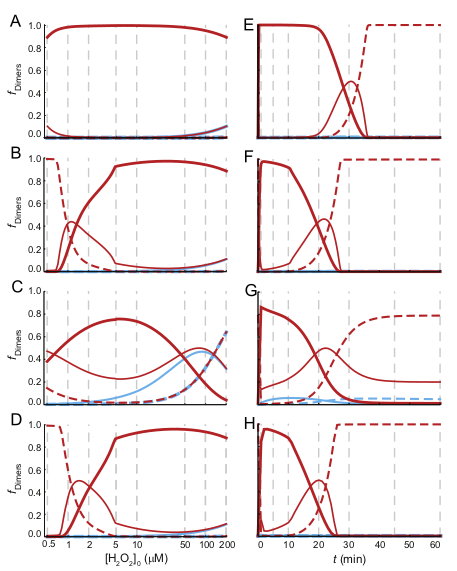

In [12]:
Image("Benfeitas 2014 fig3.png")

#### Data and sims

In [13]:
def do_Benfig3_H2O2scan(mod, H2O2_range,end = 600):
    """
    Performs the steady-state simulations of Benfeitas fig3.
    """
    # Check if model has H2O2 fixed
    if not hasattr(mod, "H2O2_init"):
        print("Model does not contain H2O2_init")

    # Set up data dict
    benfig3_H2O2scan_data = dict()
    for species in mod.species:
        benfig3_H2O2scan_data[species] = []

    # Simulate for 10 min
    for H2O2 in H2O2_range:

        # Adjust model
        orig = getattr(mod, "eH2O2_init")
        setattr(mod, "eH2O2_init",H2O2)

        # Simulate
        mod.doSim(points=2,end=end)
        data,labels = mod.data_sim.getAllSimData(lbls=True)

        # Store data
        for species in mod.species:
            benfig3_H2O2scan_data[species].append(data[-1,labels.index(species)])

        # Restore model
        setattr(mod, "eH2O2_init",orig)

    return benfig3_H2O2scan_data

def do_Benfig3_timesim(mod,points=100,end=3600):
    """
    Performs the time-coarse simulations of Benfeitas fig3.
    """
    mod.doSim(points=points,end=end)
    data,labels = mod.data_sim.getAllSimData(lbls = True)
    
    benfig3_timesim_data = dict()
    for species in mod.species:
        benfig3_timesim_data[species] = data[:,labels.index(species)]
    
    return benfig3_timesim_data

def process_Benfig3_data(data, Prx_species_list, t_dimers):
    """
    Processes the data from steady-state and time-coarse simulations of Benfeitas fig3.
    """
    sim_length = len(list(data.values())[0])
    
    # Set up plot data dict
    benfig3_plot_data = {"0SS_no_sulfi": np.zeros(sim_length),
                         "1SS_no_sulfi": np.zeros(sim_length),
                         "2SS": np.zeros(sim_length),
                         "0SS_sulfi": np.zeros(sim_length),
                         "1SS_sulfi": np.zeros(sim_length)}

    
    for species in Prx_species_list:
        species_conc_data = data[species]
        dimer_species_list = species.split("__")
        
        for dimer_species in dimer_species_list:
            sites = [i.strip("i") for i in dimer_species.split("_")] # Some models have "inhibiited" sites

            for sim_point, species_conc in enumerate(species_conc_data):

                if "SS" not in sites and "SO2H" not in sites:
                    # Thin red dashed line
                    benfig3_plot_data["0SS_no_sulfi"][sim_point] += species_conc/t_dimers

                elif "SS" not in sites and "SO2H" in sites:
                    
                    benfig3_plot_data["0SS_sulfi"][sim_point] += species_conc/t_dimers
                    benfig3_plot_data["0SS_no_sulfi"][sim_point] += species_conc/t_dimers ## see note below

                elif "SS" == sites[0] and "SS" == sites[1]:
                    # Thick red solid line
                    benfig3_plot_data["2SS"][sim_point] += species_conc/t_dimers

                elif "SS" in sites and "SO2H" not in sites:
                    # SS_SS won't get here because it's already been caught
                    # Thin red solid line
                    benfig3_plot_data["1SS_no_sulfi"][sim_point] += species_conc/t_dimers

                elif "SS" in sites and "SO2H" in sites:
                    benfig3_plot_data["1SS_sulfi"][sim_point] += species_conc/t_dimers
                    benfig3_plot_data["1SS_no_sulfi"][sim_point] += species_conc/t_dimers ## see note below

                else:
                    print(f"WARNING: {dimer_species} slipped through data processing")
                    
    # Note: From reading the paper I thought these lines shouldn't be here 
    # but they are needed to replicate the figures .   
    
    return benfig3_plot_data



In [14]:
# Adjust intracellular H2O2 production
mod_A_H2O2prod_orig = getattr(mod_A, "H2O2_production_v")
mod_B_H2O2prod_orig = getattr(mod_B, "H2O2_production_v")
mod_A_dec_nohyp_H2O2prod_orig = getattr(mod_A_dec_nohyp, "H2O2_production_v")

H2O2prod = 0.057 # for this fig
setattr(mod_A, "H2O2_production_v", H2O2prod)
setattr(mod_B, "H2O2_production_v", H2O2prod)
setattr(mod_A_dec_nohyp, "H2O2_production_v", H2O2prod)

# Adjust Plasma to experimental hematocrit
cells = 5*10**(9)

mod_A_Plasma_orig = getattr(mod_A, "Plasma_init")
mod_B_Plasma_orig = getattr(mod_B, "Plasma_init")
mod_A_dec_nohyp_Plasma_orig = getattr(mod_A_dec_nohyp, "Plasma_init")

setattr(mod_A, "Plasma_init", 1/(cells*mod_A.Compartment_1))
setattr(mod_B, "Plasma_init", 1/(cells*mod_B.Compartment_1))
setattr(mod_A_dec_nohyp, "Plasma_init", 1/(cells*mod_A_dec_nohyp.Compartment_1))

# Store eH2O2_init
mod_A_eH2O2_init_orig = getattr(mod_A,"eH2O2_init")
mod_B_eH2O2_init_orig = getattr(mod_B,"eH2O2_init")
mod_A_dec_nohyp_eH2O2_init_orig = getattr(mod_A_dec_nohyp,"eH2O2_init")

# Get Prx species list
mod_A_Prx_pos_in_conserved = 4 # mod.conserved_sums.split("\n") to get this
mod_A_Prx_species = [i.split("}")[1].strip() for i in mod_A.conserved_sums.split("\n")[mod_A_Prx_pos_in_conserved].split("=")[0].split(" + ")[1:]]
mod_B_Prx_pos_in_conserved = 2 # mod.conserved_sums.split("\n") to get this
mod_B_Prx_species = [i.split("}")[1].strip() for i in mod_B.conserved_sums.split("\n")[mod_B_Prx_pos_in_conserved].split("=")[0].split(" + ")[1:]]
mod_A_dec_nohyp_Prx_pos_in_conserved = 4 # mod.conserved_sums.split("\n") to get this
mod_A_dec_nohyp_Prx_species = [i.split("}")[1].strip() for i in mod_A_dec_nohyp.conserved_sums.split("\n")[mod_A_dec_nohyp_Prx_pos_in_conserved].split("=")[0].split(" + ")[1:]]

## Steady-state simulations
H2O2_range = np.logspace(-0.30102999,2.30103,49)

# Get t_dimers (the built in t_dimers doesn't work for decamer model)
mod_A_t_dimers = float(mod_A.conserved_sums.split("\n")[mod_A_pos_in_conserved].split(" = ")[1])
mod_B_t_dimers = float(mod_B.conserved_sums.split("\n")[mod_B_pos_in_conserved].split(" = ")[1])
mod_A_dec_nohyp_t_dimers = float(mod_A_dec_nohyp.conserved_sums.split("\n")[mod_A_dec_nohyp_pos_in_conserved].split(" = ")[1])*5

# Do simulations
mod_A_H2O2scan_data = do_Benfig3_H2O2scan(mod_A, H2O2_range)
mod_A_benfig3_H2O2scan_plots = process_Benfig3_data(mod_A_H2O2scan_data,mod_A_Prx_species,mod_A_t_dimers)
mod_B_H2O2scan_data = do_Benfig3_H2O2scan(mod_B, H2O2_range)
mod_B_benfig3_H2O2scan_plots = process_Benfig3_data(mod_B_H2O2scan_data,mod_B_Prx_species,mod_B_t_dimers)
mod_A_dec_nohyp_H2O2scan_data = do_Benfig3_H2O2scan(mod_A_dec_nohyp, H2O2_range)
mod_A_dec_nohyp_benfig3_H2O2scan_plots = process_Benfig3_data(mod_A_dec_nohyp_H2O2scan_data,mod_A_dec_nohyp_Prx_species,mod_A_dec_nohyp_t_dimers)

## Time simulations
H2O2_bolus_added_CONC_ = 5

# Adjust bolus
setattr(mod_A, "eH2O2_init", H2O2_bolus_added_CONC_)
setattr(mod_B, "eH2O2_init", H2O2_bolus_added_CONC_)
setattr(mod_A_dec_nohyp, "eH2O2_init", H2O2_bolus_added_CONC_)

# Do simulations
mod_A_timesim_data = do_Benfig3_timesim(mod_A)
mod_A_benfig3_timesim_plots = process_Benfig3_data(mod_A_timesim_data,mod_A_Prx_species,mod_A_t_dimers)
mod_B_timesim_data = do_Benfig3_timesim(mod_B)
mod_B_benfig3_timesim_plots = process_Benfig3_data(mod_B_timesim_data,mod_B_Prx_species,mod_B_t_dimers)
mod_A_dec_nohyp_timesim_data = do_Benfig3_timesim(mod_A_dec_nohyp)
mod_A_dec_nohyp_benfig3_timesim_plots = process_Benfig3_data(mod_A_dec_nohyp_timesim_data,mod_A_dec_nohyp_Prx_species,mod_A_dec_nohyp_t_dimers)

## Restore model
setattr(mod_A, "Plasma_init", mod_A_Plasma_orig)
setattr(mod_B, "Plasma_init", mod_B_Plasma_orig)
setattr(mod_A_dec_nohyp, "Plasma_init", mod_A_dec_nohyp_Plasma_orig)

setattr(mod_A, "H2O2_production_v", mod_A_H2O2prod_orig)
setattr(mod_B, "H2O2_production_v", mod_B_H2O2prod_orig)
setattr(mod_A_dec_nohyp, "H2O2_production_v", mod_A_dec_nohyp_H2O2prod_orig)

setattr(mod_A,"eH2O2_init",mod_A_eH2O2_init_orig)
setattr(mod_B,"eH2O2_init",mod_B_eH2O2_init_orig)
setattr(mod_A_dec_nohyp,"eH2O2_init",mod_A_dec_nohyp_eH2O2_init_orig)

AssignRules:29: RuntimeWarning: invalid value encountered in double_scalars
AssignRules:30: RuntimeWarning: invalid value encountered in double_scalars
AssignRules:31: RuntimeWarning: invalid value encountered in double_scalars
AssignRules:33: RuntimeWarning: divide by zero encountered in double_scalars
AssignRules:34: RuntimeWarning: invalid value encountered in double_scalars
<string>:1: RuntimeWarning: divide by zero encountered in divide
<string>:1: RuntimeWarning: invalid value encountered in divide


AssignRules:32: RuntimeWarning: invalid value encountered in double_scalars
AssignRules:34: RuntimeWarning: divide by zero encountered in double_scalars
AssignRules:35: RuntimeWarning: invalid value encountered in double_scalars


#### Simulated figure (figure 6 in our paper)

/tmp/ipykernel_94435/1062205087.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


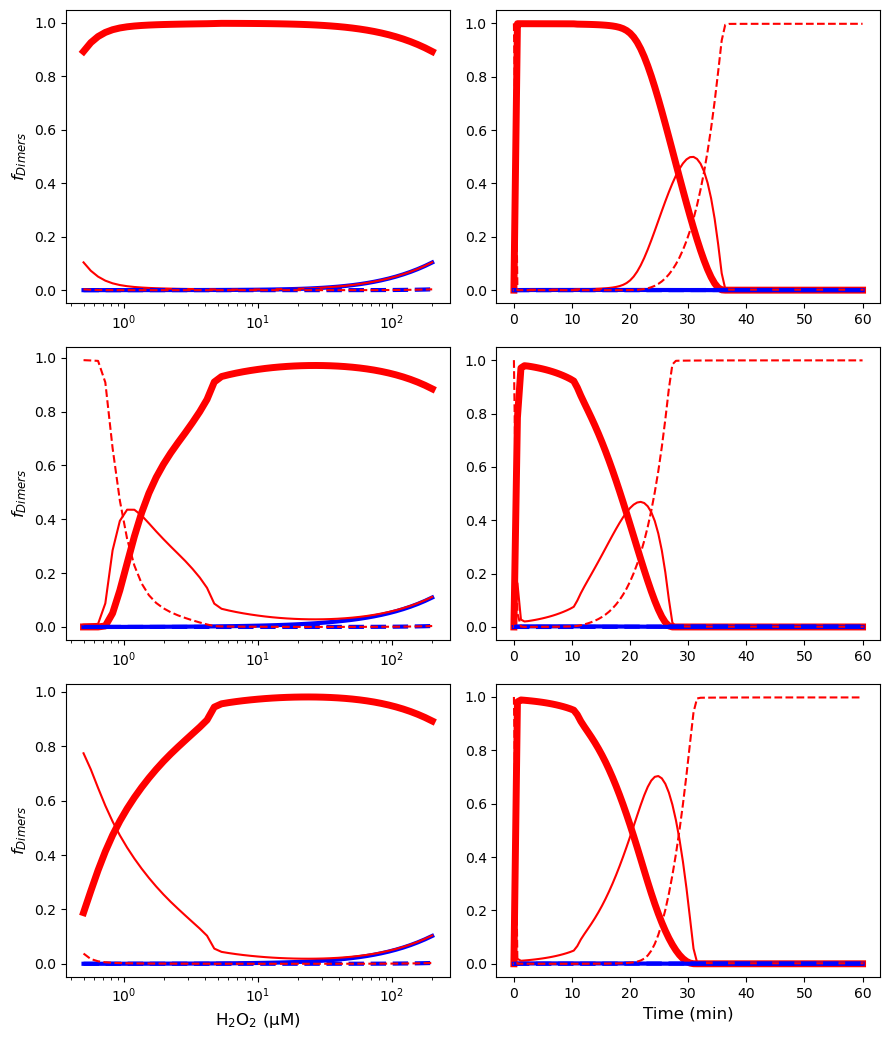

In [15]:
rows = 3
cols = 2
f, axarr = plt.subplots(rows,cols)
f.set_size_inches(w=cols*mpl_width, h=rows*mpl_height)

## Steady-state simulations
ax = axarr.flat[0]
ax.semilogx(H2O2_range,mod_A_benfig3_H2O2scan_plots["2SS"], 'r-',lw=5)
ax.semilogx(H2O2_range,mod_A_benfig3_H2O2scan_plots["1SS_sulfi"], 'b-',lw=3)
ax.semilogx(H2O2_range,mod_A_benfig3_H2O2scan_plots["1SS_no_sulfi"], 'r-')
ax.semilogx(H2O2_range,mod_A_benfig3_H2O2scan_plots["0SS_sulfi"], 'b--',lw=3)
ax.semilogx(H2O2_range,mod_A_benfig3_H2O2scan_plots["0SS_no_sulfi"],'r--')
ax.set_ylabel('$f_{Dimers}$', fontsize = mpl_ylabel_fontsize)

ax = axarr.flat[2]
ax.semilogx(H2O2_range,mod_B_benfig3_H2O2scan_plots["2SS"], 'r-',lw=5)
ax.semilogx(H2O2_range,mod_B_benfig3_H2O2scan_plots["1SS_sulfi"], 'b-',lw=3)
ax.semilogx(H2O2_range,mod_B_benfig3_H2O2scan_plots["1SS_no_sulfi"], 'r-')
ax.semilogx(H2O2_range,mod_B_benfig3_H2O2scan_plots["0SS_sulfi"], 'b--',lw=3)
ax.semilogx(H2O2_range,mod_B_benfig3_H2O2scan_plots["0SS_no_sulfi"],'r--')
ax.set_ylabel('$f_{Dimers}$', fontsize = mpl_ylabel_fontsize)

ax = axarr.flat[4]
ax.semilogx(H2O2_range,mod_A_dec_nohyp_benfig3_H2O2scan_plots["2SS"], 'r-',lw=5)
ax.semilogx(H2O2_range,mod_A_dec_nohyp_benfig3_H2O2scan_plots["1SS_sulfi"], 'b-',lw=3)
ax.semilogx(H2O2_range,mod_A_dec_nohyp_benfig3_H2O2scan_plots["1SS_no_sulfi"], 'r-')
ax.semilogx(H2O2_range,mod_A_dec_nohyp_benfig3_H2O2scan_plots["0SS_sulfi"], 'b--',lw=3)
ax.semilogx(H2O2_range,mod_A_dec_nohyp_benfig3_H2O2scan_plots["0SS_no_sulfi"],'r--')
ax.set_ylabel('$f_{Dimers}$', fontsize = mpl_ylabel_fontsize)
ax.set_xlabel(f'H$_2$O$_2$ ({mu}M)', fontsize = mpl_xlabel_fontsize)

## Time simulations
ax = axarr.flat[1]
ax.plot(mod_A.data_sim.getTime()/60,mod_A_benfig3_timesim_plots["2SS"], 'r-',lw=5)
ax.plot(mod_A.data_sim.getTime()/60,mod_A_benfig3_timesim_plots["1SS_sulfi"], 'b-',lw=3)
ax.plot(mod_A.data_sim.getTime()/60,mod_A_benfig3_timesim_plots["1SS_no_sulfi"], 'r-')
ax.plot(mod_A.data_sim.getTime()/60,mod_A_benfig3_timesim_plots["0SS_sulfi"], 'b--',lw=3)
ax.plot(mod_A.data_sim.getTime()/60,mod_A_benfig3_timesim_plots["0SS_no_sulfi"],'r--')

ax = axarr.flat[3]
ax.plot(mod_B.data_sim.getTime()/60,mod_B_benfig3_timesim_plots["2SS"], 'r-',lw=5)
ax.plot(mod_B.data_sim.getTime()/60,mod_B_benfig3_timesim_plots["1SS_sulfi"], 'b-',lw=3)
ax.plot(mod_B.data_sim.getTime()/60,mod_B_benfig3_timesim_plots["1SS_no_sulfi"], 'r-')
ax.plot(mod_B.data_sim.getTime()/60,mod_B_benfig3_timesim_plots["0SS_sulfi"], 'b--',lw=3)
ax.plot(mod_B.data_sim.getTime()/60,mod_B_benfig3_timesim_plots["0SS_no_sulfi"],'r--')

ax = axarr.flat[5]
ax.plot(mod_A_dec_nohyp.data_sim.getTime()/60,mod_A_dec_nohyp_benfig3_timesim_plots["2SS"], 'r-',lw=5)
ax.plot(mod_A_dec_nohyp.data_sim.getTime()/60,mod_A_dec_nohyp_benfig3_timesim_plots["1SS_sulfi"], 'b-',lw=3)
ax.plot(mod_A_dec_nohyp.data_sim.getTime()/60,mod_A_dec_nohyp_benfig3_timesim_plots["1SS_no_sulfi"], 'r-')
ax.plot(mod_A_dec_nohyp.data_sim.getTime()/60,mod_A_dec_nohyp_benfig3_timesim_plots["0SS_sulfi"], 'b--',lw=3)
ax.plot(mod_A_dec_nohyp.data_sim.getTime()/60,mod_A_dec_nohyp_benfig3_timesim_plots["0SS_no_sulfi"],'r--')
ax.set_xlabel('Time (min)', fontsize = mpl_xlabel_fontsize)

f.tight_layout()
f.show()

The plots above are repeated below solely in order to save them as individual files for publication.

/tmp/ipykernel_94435/3195653590.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


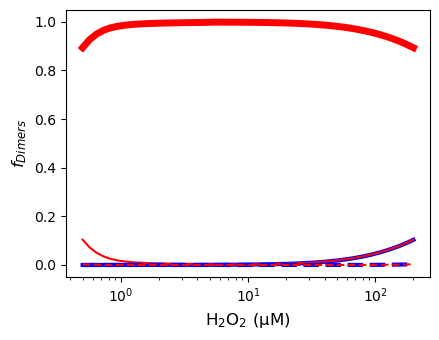

In [16]:
rows = 1
cols = 1
f, axarr = plt.subplots(rows,cols)
f.set_size_inches(w=cols*mpl_width, h=rows*mpl_height)

axarr.semilogx(H2O2_range,mod_A_benfig3_H2O2scan_plots["2SS"], 'r-',lw=5)
axarr.semilogx(H2O2_range,mod_A_benfig3_H2O2scan_plots["1SS_sulfi"], 'b-',lw=3)
axarr.semilogx(H2O2_range,mod_A_benfig3_H2O2scan_plots["1SS_no_sulfi"], 'r-')
axarr.semilogx(H2O2_range,mod_A_benfig3_H2O2scan_plots["0SS_sulfi"], 'b--',lw=3)
axarr.semilogx(H2O2_range,mod_A_benfig3_H2O2scan_plots["0SS_no_sulfi"],'r--')

axarr.set_ylabel('$f_{Dimers}$', fontsize = mpl_ylabel_fontsize)
axarr.set_xlabel(f'H$_2$O$_2$ ({mu}M)', fontsize = mpl_xlabel_fontsize)

f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,"Prx_RBC_modA_species_vs_H2O2.pdf"),dpi= mpl_dpi)

/tmp/ipykernel_94435/821344696.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


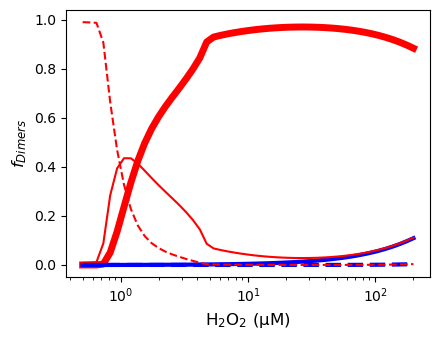

In [17]:
rows = 1
cols = 1
f, axarr = plt.subplots(rows,cols)
f.set_size_inches(w=cols*mpl_width, h=rows*mpl_height)

axarr.semilogx(H2O2_range,mod_B_benfig3_H2O2scan_plots["2SS"], 'r-',lw=5)
axarr.semilogx(H2O2_range,mod_B_benfig3_H2O2scan_plots["1SS_sulfi"], 'b-',lw=3)
axarr.semilogx(H2O2_range,mod_B_benfig3_H2O2scan_plots["1SS_no_sulfi"], 'r-')
axarr.semilogx(H2O2_range,mod_B_benfig3_H2O2scan_plots["0SS_sulfi"], 'b--',lw=3)
axarr.semilogx(H2O2_range,mod_B_benfig3_H2O2scan_plots["0SS_no_sulfi"],'r--')

axarr.set_ylabel('$f_{Dimers}$', fontsize = mpl_ylabel_fontsize)
axarr.set_xlabel(f'H$_2$O$_2$ ({mu}M)', fontsize = mpl_xlabel_fontsize)

f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,"Prx_RBC_modB_species_vs_H2O2.pdf"),dpi= mpl_dpi)

/tmp/ipykernel_94435/3711234540.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


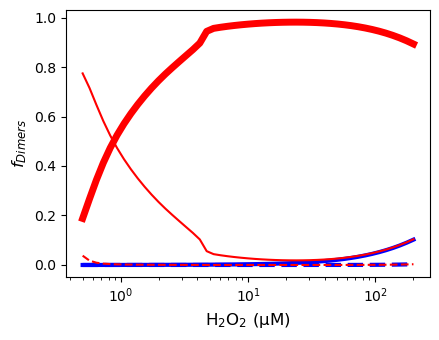

In [18]:
rows = 1
cols = 1
f, axarr = plt.subplots(rows,cols)
f.set_size_inches(w=cols*mpl_width, h=rows*mpl_height)

axarr.semilogx(H2O2_range,mod_A_dec_nohyp_benfig3_H2O2scan_plots["2SS"], 'r-',lw=5)
axarr.semilogx(H2O2_range,mod_A_dec_nohyp_benfig3_H2O2scan_plots["1SS_sulfi"], 'b-',lw=3)
axarr.semilogx(H2O2_range,mod_A_dec_nohyp_benfig3_H2O2scan_plots["1SS_no_sulfi"], 'r-')
axarr.semilogx(H2O2_range,mod_A_dec_nohyp_benfig3_H2O2scan_plots["0SS_sulfi"], 'b--',lw=3)
axarr.semilogx(H2O2_range,mod_A_dec_nohyp_benfig3_H2O2scan_plots["0SS_no_sulfi"],'r--')

axarr.set_ylabel('$f_{Dimers}$', fontsize = mpl_ylabel_fontsize)
axarr.set_xlabel(f'H$_2$O$_2$ ({mu}M)', fontsize = mpl_xlabel_fontsize)

f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,"Prx_RBC_modA_decamer_species_vs_H2O2.pdf"),dpi= mpl_dpi)

/tmp/ipykernel_94435/3901478993.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


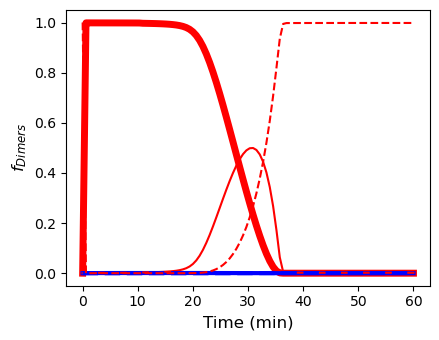

In [19]:
rows = 1
cols = 1
f, axarr = plt.subplots(rows,cols)
f.set_size_inches(w=cols*mpl_width, h=rows*mpl_height)

axarr.plot(mod_A.data_sim.getTime()/60,mod_A_benfig3_timesim_plots["2SS"], 'r-',lw=5)
axarr.plot(mod_A.data_sim.getTime()/60,mod_A_benfig3_timesim_plots["1SS_sulfi"], 'b-',lw=3)
axarr.plot(mod_A.data_sim.getTime()/60,mod_A_benfig3_timesim_plots["1SS_no_sulfi"], 'r-')
axarr.plot(mod_A.data_sim.getTime()/60,mod_A_benfig3_timesim_plots["0SS_sulfi"], 'b--',lw=3)
axarr.plot(mod_A.data_sim.getTime()/60,mod_A_benfig3_timesim_plots["0SS_no_sulfi"],'r--')

axarr.set_ylabel('$f_{Dimers}$', fontsize = mpl_ylabel_fontsize)
axarr.set_xlabel('Time (min)', fontsize = mpl_xlabel_fontsize)

f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,"Prx_RBC_modA_species_vs_time.pdf"),dpi= mpl_dpi)

/tmp/ipykernel_94435/356735236.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


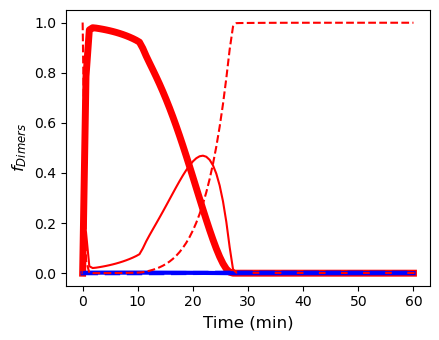

In [20]:
rows = 1
cols = 1
f, axarr = plt.subplots(rows,cols)
f.set_size_inches(w=cols*mpl_width, h=rows*mpl_height)

axarr.plot(mod_B.data_sim.getTime()/60,mod_B_benfig3_timesim_plots["2SS"], 'r-',lw=5)
axarr.plot(mod_B.data_sim.getTime()/60,mod_B_benfig3_timesim_plots["1SS_sulfi"], 'b-',lw=3)
axarr.plot(mod_B.data_sim.getTime()/60,mod_B_benfig3_timesim_plots["1SS_no_sulfi"], 'r-')
axarr.plot(mod_B.data_sim.getTime()/60,mod_B_benfig3_timesim_plots["0SS_sulfi"], 'b--',lw=3)
axarr.plot(mod_B.data_sim.getTime()/60,mod_B_benfig3_timesim_plots["0SS_no_sulfi"],'r--')

axarr.set_ylabel('$f_{Dimers}$', fontsize = mpl_ylabel_fontsize)
axarr.set_xlabel('Time (min)', fontsize = mpl_xlabel_fontsize)

f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,"Prx_RBC_modB_species_vs_time.pdf"),dpi= mpl_dpi)

/tmp/ipykernel_94435/2316948338.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


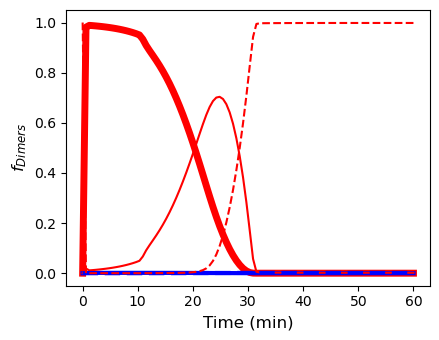

In [21]:
rows = 1
cols = 1
f, axarr = plt.subplots(rows,cols)
f.set_size_inches(w=cols*mpl_width, h=rows*mpl_height)

axarr.plot(mod_A_dec_nohyp.data_sim.getTime()/60,mod_A_dec_nohyp_benfig3_timesim_plots["2SS"], 'r-',lw=5)
axarr.plot(mod_A_dec_nohyp.data_sim.getTime()/60,mod_A_dec_nohyp_benfig3_timesim_plots["1SS_sulfi"], 'b-',lw=3)
axarr.plot(mod_A_dec_nohyp.data_sim.getTime()/60,mod_A_dec_nohyp_benfig3_timesim_plots["1SS_no_sulfi"], 'r-')
axarr.plot(mod_A_dec_nohyp.data_sim.getTime()/60,mod_A_dec_nohyp_benfig3_timesim_plots["0SS_sulfi"], 'b--',lw=3)
axarr.plot(mod_A_dec_nohyp.data_sim.getTime()/60,mod_A_dec_nohyp_benfig3_timesim_plots["0SS_no_sulfi"],'r--')
axarr.set_ylabel('$f_{Dimers}$', fontsize = mpl_ylabel_fontsize)
axarr.set_xlabel('Time (min)', fontsize = mpl_xlabel_fontsize)

f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,"Prx_RBC_modA_decamer_species_vs_time.pdf"),dpi= mpl_dpi)

### Fig 4

Fig. 4. Steady-state responses of alternative designs of the Prx2 redox cycle in H 2 O 2 metabolism to changes in H 2 O 2 supply. Cyan, Design A; black, Design B; green, Design C;
dashed red, Design D. Each design corresponds to the respective model variant described in Table 1. Note the logarithmic scales, except for E(Trx) in (G). (A) H 2 O 2
concentration. Note (i) the extremely low H 2 O 2 concentrations at low v sup and very abrupt increase for Design A and (ii) the higher H 2 O 2 concentrations at intermediate v sup
for Design C. (B) Fraction of Prx2 monomers in reduced form. Note (i) the abrupt decrease for Design A occurring at v sup values about half of those causing a milder decrease
for Designs B and D and (ii) the gradual decrease for Design C, starting at very low v sup and resulting in most Prx2 being oxidized at intermediate v sup . (C) Ratio between rates
of NADPH and H 2 O 2 consumption. Note (i) the much higher NADPH consumed per H 2 O 2 at low v sup for Design A and (ii) the lower NADPH consumption per H 2 O 2 for Design
C, reflecting respectively the high and low contributions of Prx2 for H 2 O 2 elimination under these designs. (D) Fraction of Prx2 monomers in sulfenic form. (E) Fraction of Trx
with the active site oxidized. Note the much lower accumulation of this form under Design C. (F) Fraction of Prx2 monomers in sulfinic form. Note (i) the much higher values
under Design C and (ii) the high gain (2) over most of the v sup range under all designs. (G) Redox potential of the Trx active site. (H) Fraction of Prx2 monomers in disulfide
form. In (D–H), note (i) the higher dynamic ranges provided by Designs B and D compared to Designs A and C; (ii) except in (F), the low gains and very low dynamic range
provided by Design C. In (B (inset), G, and H) note the better decisiveness provided by Design B vs Design D. Accumulation of Prx2 in sulfenic (D) and sulfinic (F) forms is
negligible under Designs A, B, and D, but not under Design C.

#### Published figure

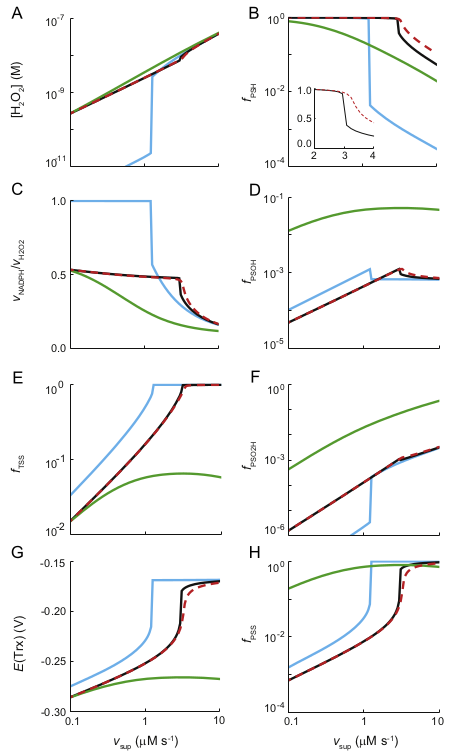

In [22]:
Image("Benfeitas 2014 fig4.png")

#### Data and sims

In [23]:
def do_Benfig4_H2O2scan(mod, H2O2_range,end = 360000):
    """
    Performs the simulations of Benfeitas fig4 after adjusting the model to simulation conditions.
    """
    # Check if model has H2O2 fixed
    if not hasattr(mod, "H2O2_init"):
        print("Model does not contain H2O2_init")

    # Set up data dict
    mod.doSim(points=2,end=1)
    benfig4_H2O2scan_data = dict()
    for label in mod.sim.dtype.names:
        benfig4_H2O2scan_data[label] = np.zeros((len(H2O2_range)))
        
    # Simulate for 10 min
    for count,H2O2 in enumerate(H2O2_range):

        # Adjust model and store original 
        orig = getattr(mod, "H2O2_production_v")
        setattr(mod, "H2O2_production_v",H2O2)

        # Simulate
        mod.doSim(points=2,end=end)

        # Store data
        for label in mod.sim.dtype.names:
            benfig4_H2O2scan_data[label][count] = mod.sim[label][-1]

        # Restore model
        setattr(mod, "H2O2_production_v",orig)

    return benfig4_H2O2scan_data

def get_rxn_rates_summed_by_type(data,data_labels,output_labels):
    """
    Sums the reaction rate by the reaction type.
    Requires "output_labels" to be globally defined.
    """
    n_output_labels = len(output_labels)
    n_x_data_points = len(data[data_labels[0]])
    output_data = np.zeros((n_output_labels,n_x_data_points))
    
    consti_rxns = dict()
    for count,output_label in enumerate(output_labels):
        consti_rxns[output_label] = []
        for data_label in data_labels:
            if output_label == data_label[-len(output_label):] or output_label == data_label[:len(output_label)]:
                consti_rxns[output_label].append(data_label)
                output_data[count,:] += data[data_label]
                
    output_data = np.rec.fromarrays(output_data,names=output_labels)

    return output_data,consti_rxns

# define globals required by get_rxn_rates_summed_by_type()
rxn_prefixes = ["Trx_red", "Cat", "NADP_reduction", "NADPH_seq", "NADP_seq","GPx1",'GSR']
rxn_suffixes = ["_ox", "_oox", "_disulf_form", "_srx", "_inac","_Trx2SH","_Trx2SOH"]

output_labels = rxn_prefixes + rxn_suffixes


In [24]:
# Store original values to restore model after simulation 
mod_A_H2O2prod_orig = getattr(mod_A, "H2O2_production_v")
mod_B_H2O2prod_orig = getattr(mod_B, "H2O2_production_v")
mod_A_dec_nohyp_H2O2prod_orig = getattr(mod_A_dec_nohyp, "H2O2_production_v")

# Do simulations
# Note: models are adjusted to simulation conditions in do_Benfig4_H2O2scan()
fig4_H2O2_scan_range = np.linspace(0.1,10,51)

mod_A_Benfig4_H2O2scan_data = do_Benfig4_H2O2scan(mod_A,fig4_H2O2_scan_range)
mod_B_Benfig4_H2O2scan_data = do_Benfig4_H2O2scan(mod_B,fig4_H2O2_scan_range)
mod_A_dec_nohyp_Benfig4_H2O2scan_data = do_Benfig4_H2O2scan(mod_A_dec_nohyp,fig4_H2O2_scan_range)

# Fig 4 C calculation
mod_A_summed_rxns,x = get_rxn_rates_summed_by_type(mod_A_Benfig4_H2O2scan_data,
                                                 mod_A.reactions,
                                                 output_labels)
mod_A_v_H2O2_cons = mod_A_summed_rxns["_ox"] \
                    +mod_A_summed_rxns["_oox"] \
                    +mod_A_summed_rxns["Cat"]\
                    +mod_A_summed_rxns["GPx1"]
mod_B_summed_rxns,x = get_rxn_rates_summed_by_type(mod_B_Benfig4_H2O2scan_data,
                                                 mod_B.reactions,
                                                 output_labels)
mod_B_v_H2O2_cons = mod_B_summed_rxns["_ox"]   \
                    +mod_B_summed_rxns["_oox"] \
                    +mod_B_summed_rxns["Cat"]\
                    +mod_B_summed_rxns["GPx1"]
mod_A_dec_nohyp_summed_rxns,x = get_rxn_rates_summed_by_type(mod_A_dec_nohyp_Benfig4_H2O2scan_data,
                                                           mod_A_dec_nohyp.reactions,
                                                           output_labels)
mod_A_dec_nohyp_v_H2O2_cons = mod_A_dec_nohyp_summed_rxns["_ox"] \
                                +mod_A_dec_nohyp_summed_rxns["_oox"] \
                                +mod_A_dec_nohyp_summed_rxns["Cat"]\
                                +mod_A_dec_nohyp_summed_rxns["GPx1"]

# Fig 4 E calculation
mod_A_f_TSS = (mod_A_Benfig4_H2O2scan_data["Trx1SOH_Trx2SH"]
               +mod_A_Benfig4_H2O2scan_data["Trx1SH_Trx2SOH"]
               +2*mod_A_Benfig4_H2O2scan_data["Trx1SOH_Trx2SOH"])/(mod_A_Benfig4_H2O2scan_data["t_Trx"]*2)
mod_B_f_TSS = (mod_B_Benfig4_H2O2scan_data["Trx1SOH_Trx2SH"]
               +mod_B_Benfig4_H2O2scan_data["Trx1SH_Trx2SOH"]
               +2*mod_B_Benfig4_H2O2scan_data["Trx1SOH_Trx2SOH"])/(mod_B_Benfig4_H2O2scan_data["t_Trx"]*2)
mod_A_dec_nohyp_f_TSS = (mod_A_dec_nohyp_Benfig4_H2O2scan_data["Trx1SOH_Trx2SH"]
                         +mod_A_dec_nohyp_Benfig4_H2O2scan_data["Trx1SH_Trx2SOH"]
                         +2*mod_A_dec_nohyp_Benfig4_H2O2scan_data["Trx1SOH_Trx2SOH"])/(mod_A_dec_nohyp_Benfig4_H2O2scan_data["t_Trx"]*2)

# Fig 4 G calculation
temp_K = sp.constants.convert_temperature(37, 'Celsius', 'Kelvin')
R = sp.constants.R
F = sp.constants.physical_constants["Faraday constant"][0]
n = 2
mod_A_r_Trx = (mod_A_Benfig4_H2O2scan_data["Trx1SH_Trx2SH"]
               +mod_A_Benfig4_H2O2scan_data["Trx1SH_Trx2SOH"])/(mod_A_Benfig4_H2O2scan_data["Trx1SOH_Trx2SH"]
                                                                   +mod_A_Benfig4_H2O2scan_data["Trx1SOH_Trx2SOH"])
mod_A_E_Trx = np.array([mod_A.E0_Trx - ((temp_K*R)/(n*F))*math.log(i) for i in mod_A_r_Trx]) # Nerst
mod_B_r_Trx = (mod_B_Benfig4_H2O2scan_data["Trx1SH_Trx2SH"]
               +mod_B_Benfig4_H2O2scan_data["Trx1SH_Trx2SOH"])/(mod_B_Benfig4_H2O2scan_data["Trx1SOH_Trx2SH"]
                                                                   +mod_B_Benfig4_H2O2scan_data["Trx1SOH_Trx2SOH"])
mod_B_E_Trx = np.array([mod_B.E0_Trx - ((temp_K*R)/(n*F))*math.log(i) for i in mod_B_r_Trx]) # Nerst
mod_A_dec_nohyp_r_Trx = (mod_A_dec_nohyp_Benfig4_H2O2scan_data["Trx1SH_Trx2SH"]
                         +mod_A_dec_nohyp_Benfig4_H2O2scan_data["Trx1SH_Trx2SOH"])/(mod_A_dec_nohyp_Benfig4_H2O2scan_data["Trx1SOH_Trx2SH"]
                                                                                    +mod_A_dec_nohyp_Benfig4_H2O2scan_data["Trx1SOH_Trx2SOH"])
mod_A_dec_nohyp_E_Trx = np.array([mod_A_dec_nohyp.E0_Trx - ((temp_K*R)/(n*F))*math.log(i) for i in mod_A_dec_nohyp_r_Trx]) # Nerst

# Restore models - redundant since models are restored in do_Benfig4_H2O2scan()
setattr(mod_A, "H2O2_production_v", mod_A_H2O2prod_orig)
setattr(mod_B, "H2O2_production_v", mod_B_H2O2prod_orig)
setattr(mod_A_dec_nohyp, "H2O2_production_v", mod_A_dec_nohyp_H2O2prod_orig)

AssignRules:29: RuntimeWarning: invalid value encountered in double_scalars
AssignRules:33: RuntimeWarning: divide by zero encountered in double_scalars
AssignRules:34: RuntimeWarning: invalid value encountered in double_scalars
<string>:1: RuntimeWarning: divide by zero encountered in divide
<string>:1: RuntimeWarning: invalid value encountered in divide
AssignRules:34: RuntimeWarning: divide by zero encountered in double_scalars
AssignRules:35: RuntimeWarning: invalid value encountered in double_scalars


#### Simulated figure (figure S3 in our paper)

/tmp/ipykernel_94435/324267759.py:73: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


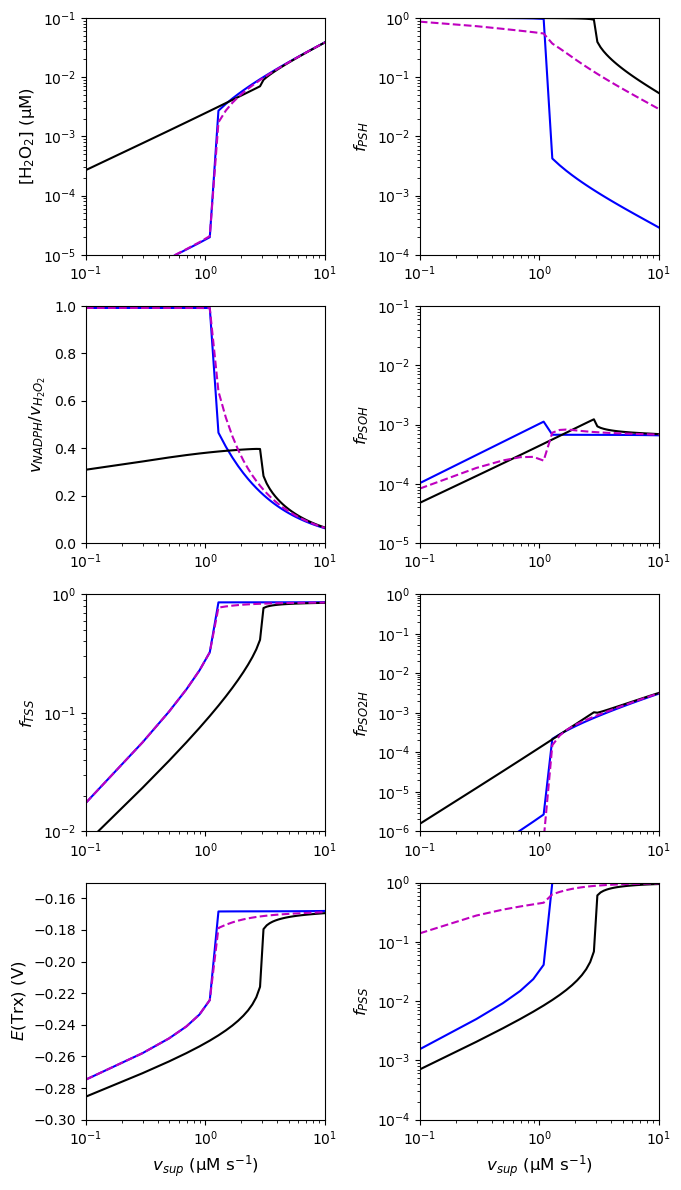

In [25]:
rows = 4
cols = 2
f, axarr = plt.subplots(rows,cols)
f.set_size_inches(w=cols*mpl_width_squarefig+1, h=rows*mpl_height_squarefig)

ax = axarr.flat[0]
ax.loglog(fig4_H2O2_scan_range, mod_A_Benfig4_H2O2scan_data["H2O2"], mod_A_line)
ax.loglog(fig4_H2O2_scan_range, mod_B_Benfig4_H2O2scan_data["H2O2"], mod_B_line)
ax.loglog(fig4_H2O2_scan_range, mod_A_dec_nohyp_Benfig4_H2O2scan_data["H2O2"], mod_A_dec_nohyp_line)
ax.set_ylabel(f'[H$_2$O$_2$] ({mu}M)', fontsize = mpl_ylabel_fontsize)
ax.set_ylim((1e-5,1e-1))
ax.set_xlim((0.1,10))

ax = axarr.flat[1]
ax.loglog(fig4_H2O2_scan_range, mod_A_Benfig4_H2O2scan_data["f_PSH"], mod_A_line)
ax.loglog(fig4_H2O2_scan_range, mod_B_Benfig4_H2O2scan_data["f_PSH"], mod_B_line)
ax.loglog(fig4_H2O2_scan_range, mod_A_dec_nohyp_Benfig4_H2O2scan_data["f_PSH"], mod_A_dec_nohyp_line)
ax.set_ylabel('$f_{PSH}$', fontsize = mpl_ylabel_fontsize)
ax.set_ylim((1e-4,1e-0))
ax.set_xlim((0.1,10))

ax = axarr.flat[2]
ax.semilogx(fig4_H2O2_scan_range, mod_A_summed_rxns["Trx_red"]/mod_A_v_H2O2_cons, mod_A_line)
ax.semilogx(fig4_H2O2_scan_range, mod_B_summed_rxns["Trx_red"]/mod_B_v_H2O2_cons, mod_B_line)
ax.semilogx(fig4_H2O2_scan_range, mod_A_dec_nohyp_summed_rxns["Trx_red"]/mod_A_dec_nohyp_v_H2O2_cons, mod_A_dec_nohyp_line)
ax.set_ylabel('$v_{NADPH}$/$v_{H_2O_2}$', fontsize = mpl_ylabel_fontsize)
ax.set_ylim((0,1))
ax.set_xlim((0.1,10))

ax = axarr.flat[3]
ax.loglog(fig4_H2O2_scan_range, mod_A_Benfig4_H2O2scan_data['f_PSOH'], mod_A_line)
ax.loglog(fig4_H2O2_scan_range, mod_B_Benfig4_H2O2scan_data['f_PSOH'], mod_B_line)
ax.loglog(fig4_H2O2_scan_range, mod_A_dec_nohyp_Benfig4_H2O2scan_data['f_PSOH'], mod_A_dec_nohyp_line)
ax.set_ylabel('$f_{PSOH}$', fontsize = mpl_ylabel_fontsize)
ax.set_ylim((1e-5,1e-1))
ax.set_xlim((0.1,10))

ax = axarr.flat[4]
ax.loglog(fig4_H2O2_scan_range, mod_A_f_TSS, mod_A_line)
ax.loglog(fig4_H2O2_scan_range, mod_B_f_TSS, mod_B_line)
ax.loglog(fig4_H2O2_scan_range, mod_A_dec_nohyp_f_TSS, mod_A_dec_nohyp_line)
ax.set_ylabel('$f_{TSS}$', fontsize = mpl_ylabel_fontsize)
ax.set_ylim((1e-2,1e-0))
ax.set_xlim((0.1,10))

ax = axarr.flat[5]
ax.loglog(fig4_H2O2_scan_range, mod_A_Benfig4_H2O2scan_data['f_PSO2H'], mod_A_line)
ax.loglog(fig4_H2O2_scan_range, mod_B_Benfig4_H2O2scan_data['f_PSO2H'], mod_B_line)
ax.loglog(fig4_H2O2_scan_range, mod_A_dec_nohyp_Benfig4_H2O2scan_data['f_PSO2H'], mod_A_dec_nohyp_line)
ax.set_ylabel('$f_{PSO2H}$', fontsize = mpl_ylabel_fontsize)
ax.set_ylim((1e-6,1e-0))
ax.set_xlim((0.1,10))

ax = axarr.flat[6]
ax.semilogx(fig4_H2O2_scan_range, mod_A_E_Trx, mod_A_line)
ax.semilogx(fig4_H2O2_scan_range, mod_B_E_Trx, mod_B_line)
ax.semilogx(fig4_H2O2_scan_range, mod_A_dec_nohyp_E_Trx, mod_A_dec_nohyp_line)
ax.set_ylabel('$E$(Trx) (V)', fontsize = mpl_ylabel_fontsize)
ax.set_xlabel('$v$$_{sup}$ '+f'({mu}M'+' s$^{-1}$)', fontsize = mpl_xlabel_fontsize)
ax.set_ylim((-0.30,-0.15))
ax.set_xlim((0.1,10))

ax = axarr.flat[7]
ax.loglog(fig4_H2O2_scan_range, mod_A_Benfig4_H2O2scan_data['f_PSS'], mod_A_line)
ax.loglog(fig4_H2O2_scan_range, mod_B_Benfig4_H2O2scan_data['f_PSS'], mod_B_line)
ax.loglog(fig4_H2O2_scan_range, mod_A_dec_nohyp_Benfig4_H2O2scan_data['f_PSS'], mod_A_dec_nohyp_line)
ax.set_ylabel('$f_{PSS}$', fontsize = mpl_ylabel_fontsize)
ax.set_xlabel('$v$$_{sup}$ '+f'({mu}M'+' s$^{-1}$)', fontsize = mpl_xlabel_fontsize)
ax.set_ylim((1e-4,1e-0))
ax.set_xlim((0.1,10))

f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,"Benfig4.pdf"),dpi= mpl_dpi)


### Fig 5

Fig. 5. Responses of intracellular H 2 O 2 concentration and Prx2 oxidation states to extracellular H 2 O 2 pulses. Time courses (A) of the intracellular H 2 O 2 concentration and
(B–E) of the fractions of Prx2 monomers with the peroxidatic Cys in thiol (B), sulfenic (C), sulfinic (D), and disulfide (E) form upon 3 s pulse of 0.5, 5, and 50 μM local plasma
H 2 O 2 concentrations. Vertical gray bars indicate the timing and duration of the H 2 O 2 pulse. The correspondence of line to design is as for Fig. 4. Recovery of the PSH pool after
the strongest H 2 O 2 pulses is delayed by strong competition of GSR for NADPH after GSSG accumulation during the pulse (see Figs. 6B and 6C). Note the strong oxidation of
Prx2 caused by even relatively weak H 2 O 2 pulses in Design D, owing to the total concentration of Prx2 in this design being less than half the dose of H 2 O 2 entering the
erythrocyte during the pulse. Note also the very slow reduction of the sulfinic Prx2 accumulated during the pulse.

#### Published figure

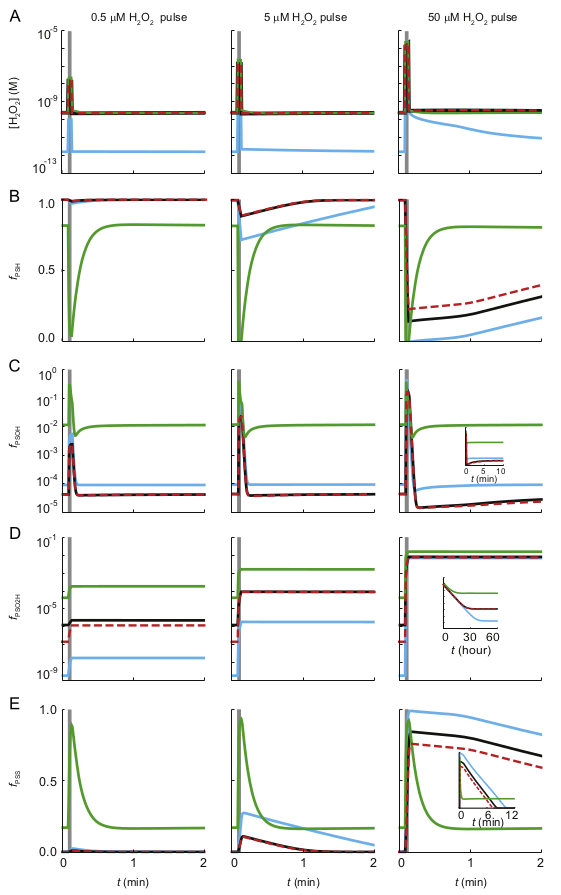

In [26]:
Image("Benfeitas 2014 fig5.png")

#### Data and sims

In [27]:
# Adjust models for simulation conditions
setattr(mod_A,"do_exH2O2_pulse",True)
setattr(mod_B,"do_exH2O2_pulse",True)
setattr(mod_A_dec_nohyp,"do_exH2O2_pulse",True)

mod_A_exH2O2_pulse_conc_orig = getattr(mod_A,"exH2O2_pulse_conc")
mod_B_exH2O2_pulse_conc_orig = getattr(mod_B,"exH2O2_pulse_conc")
mod_A_dec_nohyp_exH2O2_pulse_conc_orig = getattr(mod_A_dec_nohyp,"exH2O2_pulse_conc")

mod_A_exH2O2_pulse_length_orig = getattr(mod_A,"exH2O2_pulse_length")
mod_B_exH2O2_pulse_length_orig = getattr(mod_B,"exH2O2_pulse_length")
mod_A_dec_nohyp_exH2O2_pulse_length_orig = getattr(mod_A_dec_nohyp,"exH2O2_pulse_length")

exH2O2_pulse_length = 3
setattr(mod_A,"exH2O2_pulse_length",exH2O2_pulse_length)
setattr(mod_B,"exH2O2_pulse_length",exH2O2_pulse_length)
setattr(mod_A_dec_nohyp,"exH2O2_pulse_length",exH2O2_pulse_length)

end = 120
points = 1000

# Simulate 0.5 µM H2O2 pulse
setattr(mod_A,"exH2O2_pulse_conc",0.5)
setattr(mod_B,"exH2O2_pulse_conc",0.5)
setattr(mod_A_dec_nohyp,"exH2O2_pulse_conc",0.5)
mod_A.doSim(points=points,end=end)
mod_A_05_H2O2_data = mod_A.sim
mod_B.doSim(points=points,end=end)
mod_B_05_H2O2_data = mod_B.sim
mod_A_dec_nohyp.doSim(points=points,end=end)
mod_A_dec_nohyp_05_H2O2_data = mod_A_dec_nohyp.sim

# Simulate 5 µM H2O2 pulse
setattr(mod_A,"exH2O2_pulse_conc",5)
setattr(mod_B,"exH2O2_pulse_conc",5)
setattr(mod_A_dec_nohyp,"exH2O2_pulse_conc",5)
mod_A.doSim(points=points,end=end)
mod_A_5_H2O2_data = mod_A.sim
mod_B.doSim(points=points,end=end)
mod_B_5_H2O2_data = mod_B.sim
mod_A_dec_nohyp.doSim(points=points,end=end)
mod_A_dec_nohyp_5_H2O2_data = mod_A_dec_nohyp.sim

# Simulate 50 µM H2O2 pulse
setattr(mod_A,"exH2O2_pulse_conc",50)
setattr(mod_B,"exH2O2_pulse_conc",50)
setattr(mod_A_dec_nohyp,"exH2O2_pulse_conc",50)
mod_A.doSim(points=points,end=end)
mod_A_50_H2O2_data = mod_A.sim
mod_B.doSim(points=points,end=end)
mod_B_50_H2O2_data = mod_B.sim
mod_A_dec_nohyp.doSim(points=points,end=end)
mod_A_dec_nohyp_50_H2O2_data = mod_A_dec_nohyp.sim

# Restore models
setattr(mod_A,"do_exH2O2_pulse",False)
setattr(mod_B,"do_exH2O2_pulse",False)
setattr(mod_A_dec_nohyp,"do_exH2O2_pulse",False)

setattr(mod_A,"exH2O2_pulse_length",mod_A_exH2O2_pulse_length_orig)
setattr(mod_B,"exH2O2_pulse_length",mod_B_exH2O2_pulse_length_orig)
setattr(mod_A_dec_nohyp,"exH2O2_pulse_length",mod_A_dec_nohyp_exH2O2_pulse_length_orig)

setattr(mod_A,"exH2O2_pulse_conc",mod_A_exH2O2_pulse_conc_orig)
setattr(mod_B,"exH2O2_pulse_conc",mod_B_exH2O2_pulse_conc_orig)
setattr(mod_A_dec_nohyp,"exH2O2_pulse_conc",mod_A_dec_nohyp_exH2O2_pulse_conc_orig)



event eH2O2pulse_start is evaluating at 0.0

event eH2O2pulse_end is evaluating at 3.003003003003003
event eH2O2pulse_start is assigning at 5.045045045045045 (delay=5.0)
event eH2O2pulse_end is assigning at 8.037783275730462 (delay=5.0)


AssignRules:29: RuntimeWarning: invalid value encountered in double_scalars
AssignRules:33: RuntimeWarning: divide by zero encountered in double_scalars
AssignRules:34: RuntimeWarning: invalid value encountered in double_scalars
<string>:1: RuntimeWarning: divide by zero encountered in divide
<string>:1: RuntimeWarning: invalid value encountered in divide
AssignRules:34: RuntimeWarning: divide by zero encountered in double_scalars
AssignRules:35: RuntimeWarning: invalid value encountered in double_scalars



event eH2O2pulse_start is evaluating at 0.0

event eH2O2pulse_end is evaluating at 3.003003003003003
event eH2O2pulse_start is assigning at 5.04404835121149 (delay=5.0)
event eH2O2pulse_end is assigning at 8.036197421311202 (delay=5.0)

event eH2O2pulse_start is evaluating at 0.0

event eH2O2pulse_end is evaluating at 3.003003003003003
event eH2O2pulse_start is assigning at 5.045045045045045 (delay=5.0)
event eH2O2pulse_end is assigning at 8.018812423407752 (delay=5.0)

event eH2O2pulse_start is evaluating at 0.0

event eH2O2pulse_end is evaluating at 3.003003003003003
event eH2O2pulse_start is assigning at 5.001377754857731 (delay=5.0)
event eH2O2pulse_end is assigning at 8.036532566298938 (delay=5.0)

event eH2O2pulse_start is evaluating at 0.0

event eH2O2pulse_end is evaluating at 3.003003003003003
event eH2O2pulse_start is assigning at 5.009352998450998 (delay=5.0)
event eH2O2pulse_end is assigning at 8.040898331940104 (delay=5.0)

event eH2O2pulse_start is evaluating at 0.0

eve

#### Simulated figure (figure S4 in our paper)

/tmp/ipykernel_94435/3488750342.py:128: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


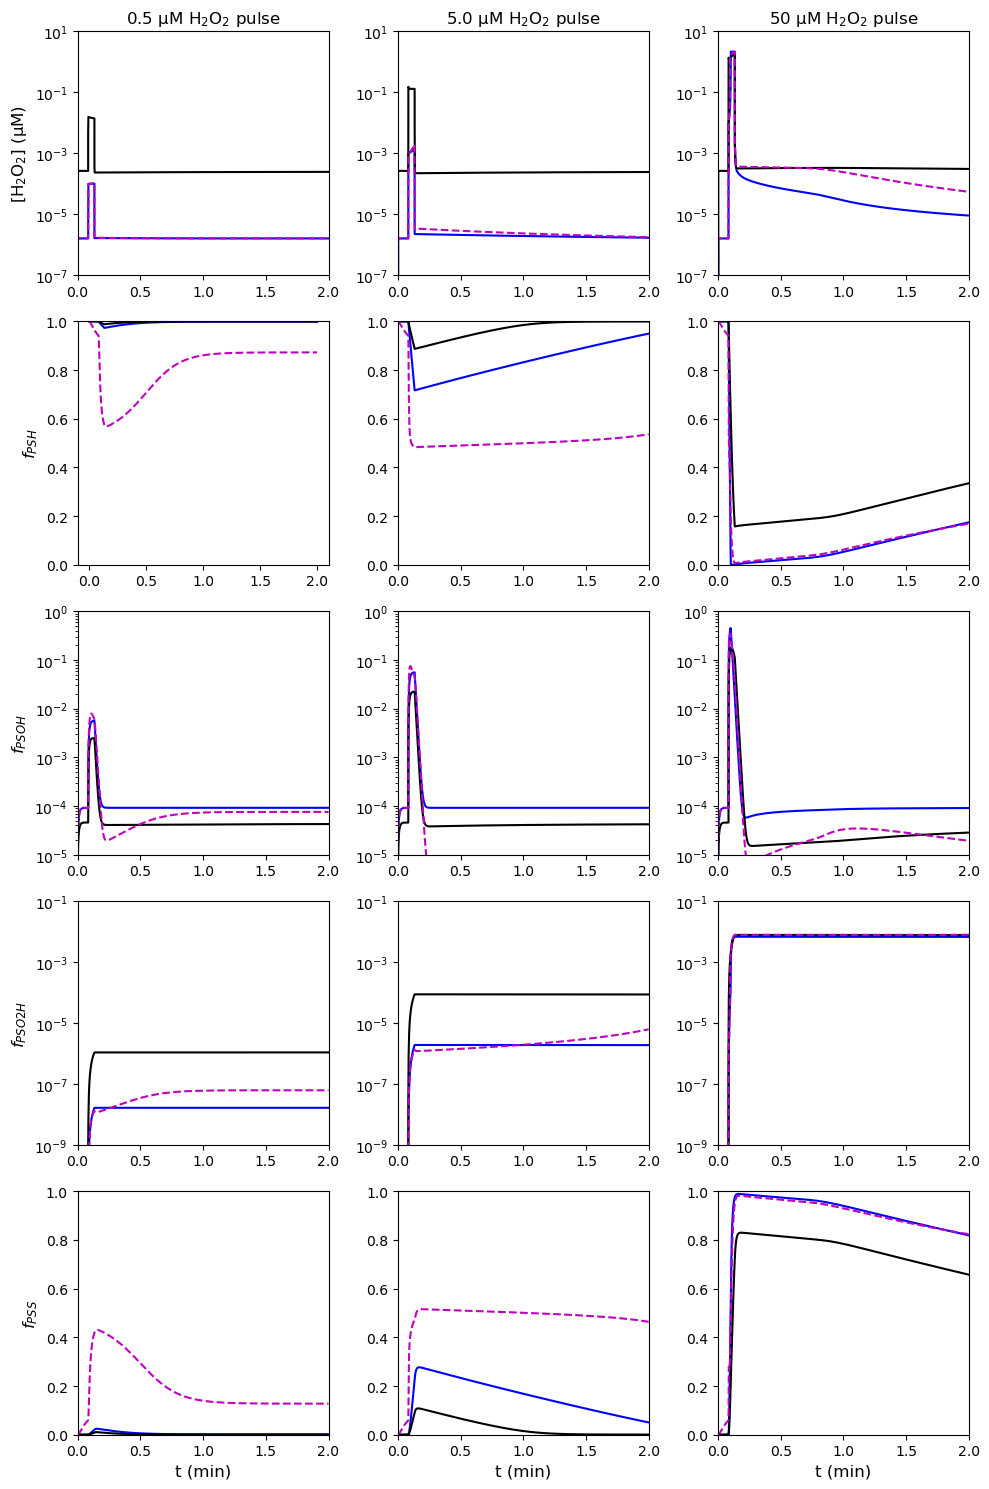

In [28]:
rows = 5
cols = 3
f, axarr = plt.subplots(rows,cols)
f.set_size_inches(w=cols*mpl_width_squarefig+1, h=rows*mpl_height_squarefig)

# 0.5 µM H2O2 pulse

ax = axarr.flat[0]
ax.semilogy(mod_A_05_H2O2_data["Time"]/60,mod_A_05_H2O2_data["H2O2"],mod_A_line)
ax.semilogy(mod_B_05_H2O2_data["Time"]/60,mod_B_05_H2O2_data["H2O2"],mod_B_line)
ax.semilogy(mod_A_dec_nohyp_05_H2O2_data["Time"]/60,mod_A_dec_nohyp_05_H2O2_data["H2O2"],mod_A_dec_nohyp_line)
ax.set_ylabel(f'[H$_2$O$_2$] ({mu}M)', fontsize = mpl_ylabel_fontsize)
ax.set_ylim((1e-7,1e1))
ax.set_xlim((0,2))
ax.set_title(f"0.5 {mu}M H$_2$O$_2$ pulse")

ax = axarr.flat[3]
ax.plot(mod_A_05_H2O2_data["Time"]/60,mod_A_05_H2O2_data["f_PSH"],mod_A_line)
ax.plot(mod_B_05_H2O2_data["Time"]/60,mod_B_05_H2O2_data["f_PSH"],mod_B_line)
ax.plot(mod_A_dec_nohyp_05_H2O2_data["Time"]/60,mod_A_dec_nohyp_05_H2O2_data["f_PSH"],mod_A_dec_nohyp_line)
ax.set_ylabel('$f_{PSH}$', fontsize = mpl_ylabel_fontsize)
ax.set_ylim((0,1))

ax = axarr.flat[6]
ax.semilogy(mod_A_05_H2O2_data["Time"]/60,mod_A_05_H2O2_data["f_PSOH"],mod_A_line)
ax.semilogy(mod_B_05_H2O2_data["Time"]/60,mod_B_05_H2O2_data["f_PSOH"],mod_B_line)
ax.semilogy(mod_A_dec_nohyp_05_H2O2_data["Time"]/60,mod_A_dec_nohyp_05_H2O2_data["f_PSOH"],mod_A_dec_nohyp_line)
ax.set_ylabel('$f_{PSOH}$', fontsize = mpl_ylabel_fontsize)
ax.set_ylim((1e-5,1e0))
ax.set_xlim((0,2))

ax = axarr.flat[9]
ax.semilogy(mod_A_05_H2O2_data["Time"]/60,mod_A_05_H2O2_data["f_PSO2H"],mod_A_line)
ax.semilogy(mod_B_05_H2O2_data["Time"]/60,mod_B_05_H2O2_data["f_PSO2H"],mod_B_line)
ax.semilogy(mod_A_dec_nohyp_05_H2O2_data["Time"]/60,mod_A_dec_nohyp_05_H2O2_data["f_PSO2H"],mod_A_dec_nohyp_line)
ax.set_ylabel('$f_{PSO2H}$', fontsize = mpl_ylabel_fontsize)
ax.set_ylim((1e-9,1e-1))
ax.set_xlim((0,2))

ax = axarr.flat[12]
ax.plot(mod_A_05_H2O2_data["Time"]/60,mod_A_05_H2O2_data["f_PSS"],mod_A_line)
ax.plot(mod_B_05_H2O2_data["Time"]/60,mod_B_05_H2O2_data["f_PSS"],mod_B_line)
ax.plot(mod_A_dec_nohyp_05_H2O2_data["Time"]/60,mod_A_dec_nohyp_05_H2O2_data["f_PSS"],mod_A_dec_nohyp_line)
ax.set_ylabel('$f_{PSS}$', fontsize = mpl_ylabel_fontsize)
ax.set_xlabel(f't (min)', fontsize = mpl_xlabel_fontsize)
ax.set_ylim((0,1))
ax.set_xlim((0,2))

# 5 µM H2O2 pulse

ax = axarr.flat[1]
ax.semilogy(mod_A_5_H2O2_data["Time"]/60,mod_A_5_H2O2_data["H2O2"],mod_A_line)
ax.semilogy(mod_B_5_H2O2_data["Time"]/60,mod_B_5_H2O2_data["H2O2"],mod_B_line)
ax.semilogy(mod_A_dec_nohyp_5_H2O2_data["Time"]/60,mod_A_dec_nohyp_5_H2O2_data["H2O2"],mod_A_dec_nohyp_line)
ax.set_ylim((1e-7,1e1))
ax.set_xlim((0,2))
ax.set_title(f"5.0 {mu}M H$_2$O$_2$ pulse")

ax = axarr.flat[4]
ax.plot(mod_A_5_H2O2_data["Time"]/60,mod_A_5_H2O2_data["f_PSH"],mod_A_line)
ax.plot(mod_B_5_H2O2_data["Time"]/60,mod_B_5_H2O2_data["f_PSH"],mod_B_line)
ax.plot(mod_A_dec_nohyp_5_H2O2_data["Time"]/60,mod_A_dec_nohyp_5_H2O2_data["f_PSH"],mod_A_dec_nohyp_line)
ax.set_ylim((0,1))
ax.set_xlim((0,2))

ax = axarr.flat[7]
ax.semilogy(mod_A_5_H2O2_data["Time"]/60,mod_A_5_H2O2_data["f_PSOH"],mod_A_line)
ax.semilogy(mod_B_5_H2O2_data["Time"]/60,mod_B_5_H2O2_data["f_PSOH"],mod_B_line)
ax.semilogy(mod_A_dec_nohyp_5_H2O2_data["Time"]/60,mod_A_dec_nohyp_5_H2O2_data["f_PSOH"],mod_A_dec_nohyp_line)
ax.set_ylim((1e-5,1e0))
ax.set_xlim((0,2))

ax = axarr.flat[10]
ax.semilogy(mod_A_5_H2O2_data["Time"]/60,mod_A_5_H2O2_data["f_PSO2H"],mod_A_line)
ax.semilogy(mod_B_5_H2O2_data["Time"]/60,mod_B_5_H2O2_data["f_PSO2H"],mod_B_line)
ax.semilogy(mod_A_dec_nohyp_5_H2O2_data["Time"]/60,mod_A_dec_nohyp_5_H2O2_data["f_PSO2H"],mod_A_dec_nohyp_line)
ax.set_ylim((1e-9,1e-1))
ax.set_xlim((0,2))

ax = axarr.flat[13]
ax.plot(mod_A_5_H2O2_data["Time"]/60,mod_A_5_H2O2_data['f_PSS'],mod_A_line)
ax.plot(mod_B_5_H2O2_data["Time"]/60,mod_B_5_H2O2_data['f_PSS'],mod_B_line)
ax.plot(mod_A_dec_nohyp_5_H2O2_data["Time"]/60,mod_A_dec_nohyp_5_H2O2_data['f_PSS'],mod_A_dec_nohyp_line)
ax.set_xlabel(f't (min)', fontsize = mpl_xlabel_fontsize)
ax.set_ylim((0,1))
ax.set_xlim((0,2))

# 50 µM H2O2 pulse

ax = axarr.flat[2]
ax.semilogy(mod_A_50_H2O2_data["Time"]/60,mod_A_50_H2O2_data["H2O2"],mod_A_line)
ax.semilogy(mod_B_50_H2O2_data["Time"]/60,mod_B_50_H2O2_data["H2O2"],mod_B_line)
ax.semilogy(mod_A_dec_nohyp_50_H2O2_data["Time"]/60,mod_A_dec_nohyp_50_H2O2_data["H2O2"],mod_A_dec_nohyp_line)
ax.set_ylim((1e-7,1e1))
ax.set_xlim((0,2))
ax.set_title(f"50 {mu}M H$_2$O$_2$ pulse")

ax = axarr.flat[5]
ax.plot(mod_A_50_H2O2_data["Time"]/60,mod_A_50_H2O2_data["f_PSH"],mod_A_line)
ax.plot(mod_B_50_H2O2_data["Time"]/60,mod_B_50_H2O2_data["f_PSH"],mod_B_line)
ax.plot(mod_A_dec_nohyp_50_H2O2_data["Time"]/60,mod_A_dec_nohyp_50_H2O2_data["f_PSH"],mod_A_dec_nohyp_line)
ax.set_ylim((0,1))
ax.set_xlim((0,2))

ax = axarr.flat[8]
ax.semilogy(mod_A_50_H2O2_data["Time"]/60,mod_A_50_H2O2_data["f_PSOH"],mod_A_line)
ax.semilogy(mod_B_50_H2O2_data["Time"]/60,mod_B_50_H2O2_data["f_PSOH"],mod_B_line)
ax.semilogy(mod_A_dec_nohyp_50_H2O2_data["Time"]/60,mod_A_dec_nohyp_50_H2O2_data["f_PSOH"],mod_A_dec_nohyp_line)
ax.set_ylim((1e-5,1e0))
ax.set_xlim((0,2))

ax = axarr.flat[11]
ax.semilogy(mod_A_50_H2O2_data["Time"]/60,mod_A_50_H2O2_data["f_PSO2H"],mod_A_line)
ax.semilogy(mod_B_50_H2O2_data["Time"]/60,mod_B_50_H2O2_data["f_PSO2H"],mod_B_line)
ax.semilogy(mod_A_dec_nohyp_50_H2O2_data["Time"]/60,mod_A_dec_nohyp_50_H2O2_data["f_PSO2H"],mod_A_dec_nohyp_line)
ax.set_ylim((1e-9,1e-1))
ax.set_xlim((0,2))

ax = axarr.flat[14]
ax.plot(mod_A_50_H2O2_data["Time"]/60,mod_A_50_H2O2_data['f_PSS'],mod_A_line)
ax.plot(mod_B_50_H2O2_data["Time"]/60,mod_B_50_H2O2_data['f_PSS'],mod_B_line)
ax.plot(mod_A_dec_nohyp_50_H2O2_data["Time"]/60,mod_A_dec_nohyp_50_H2O2_data['f_PSS'],mod_A_dec_nohyp_line)
ax.set_xlabel(f't (min)', fontsize = mpl_xlabel_fontsize)
ax.set_ylim((0,1))
ax.set_xlim((0,2))

f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,"Benfig5.pdf"),dpi= mpl_dpi)
          

### Fig 6

Fig. 6. Responses of the potentials of redox pools to extracellular H 2 O 2 pulses. The correspondence of line to model is as for Fig. 4. Time course of the redox potentials of
(A) Trx1, (B) GSH, and (C) NADPH upon 3 s pulse of 0.5, 5, and 50 μM local plasma H 2 O 2 concentrations. Vertical gray bars indicate the timing and duration of the H 2 O 2 pulse.
Note the delay in the recovery of all the redox potentials after the strongest pulses. This ensues mainly from NADPH depletion by the GSR-catalyzed reduction of GSSG
accumulated during the pulse and from the limited rate at which erythrocytes can reduce NADP þ to NADPH.

#### Published figure

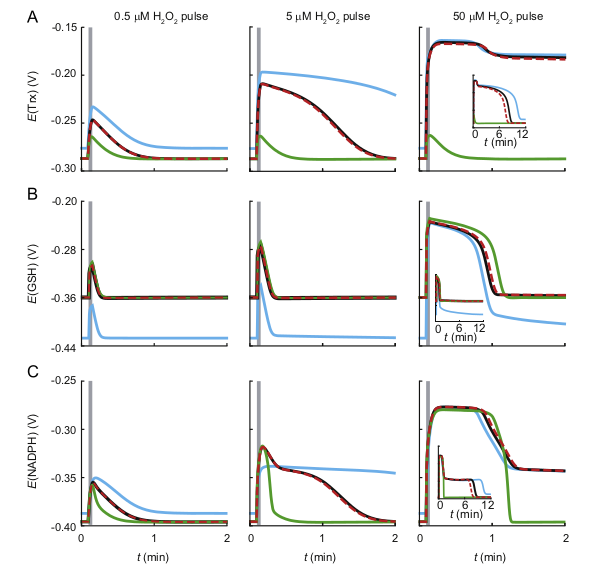

In [29]:
Image("Benfeitas 2014 fig6.png")

#### Data and sims

In [30]:
def nerst(r_species,E0,n=2,temp_C=37):
    """
    Nerst equation used to calculate redox potentials.
    """
    temp_K = sp.constants.convert_temperature(temp_C, 'Celsius', 'Kelvin')
    R = sp.constants.R
    F = sp.constants.physical_constants["Faraday constant"][0]
    E = E0 - ((temp_K*R)/(n*F))*math.log(r_species)
    return E
nerst_vec = np.vectorize(nerst)

def get_r_NADPHfree(data):
    """
    Calculates NADPH ratio.
    """
    r_NADPH_free = data["NADPHfree"]/data["NADPfree"]
    return r_NADPH_free

def get_r_GS(data):
    """
    Calculates GSH ratio.
    """
    r_GS = (data["GSH"]**2)/(data["GSSG"])
    return r_GS

def get_r_Trx(data):
    """
    Calculates Trx ratio.
    """
    r_Trx = (data["Trx1SH_Trx2SH"]+data["Trx1SH_Trx2SOH"])/(data["Trx1SOH_Trx2SH"]+data["Trx1SOH_Trx2SOH"])
    return r_Trx

In [31]:
# Note: no new simulations are performed as this figure analyses data from the fig5 simulations 

## mod_A
# Trx
mod_A_05_E_Trx = nerst_vec(get_r_Trx(mod_A_05_H2O2_data),mod_A.E0_Trx)
mod_A_5_E_Trx = nerst_vec(get_r_Trx(mod_A_5_H2O2_data),mod_A.E0_Trx)
mod_A_50_E_Trx = nerst_vec(get_r_Trx(mod_A_50_H2O2_data),mod_A.E0_Trx)

# GS
mod_A_05_E_GS = nerst_vec(get_r_GS(mod_A_05_H2O2_data),mod_A.E0_GSH)
mod_A_5_E_GS = nerst_vec(get_r_GS(mod_A_5_H2O2_data),mod_A.E0_GSH)
mod_A_50_E_GS = nerst_vec(get_r_GS(mod_A_50_H2O2_data),mod_A.E0_GSH)

# NADPH
mod_A_05_E_NADPHfree = nerst_vec(get_r_NADPHfree(mod_A_05_H2O2_data),mod_A.E0_NADPH)
mod_A_5_E_NADPHfree = nerst_vec(get_r_NADPHfree(mod_A_5_H2O2_data),mod_A.E0_NADPH)
mod_A_50_E_NADPHfree = nerst_vec(get_r_NADPHfree(mod_A_50_H2O2_data),mod_A.E0_NADPH)

## mod_B
# Trx
mod_B_05_E_Trx = nerst_vec(get_r_Trx(mod_B_05_H2O2_data),mod_B.E0_Trx)
mod_B_5_E_Trx = nerst_vec(get_r_Trx(mod_B_5_H2O2_data),mod_B.E0_Trx)
mod_B_50_E_Trx = nerst_vec(get_r_Trx(mod_B_50_H2O2_data),mod_B.E0_Trx)

# GS
mod_B_05_E_GS = nerst_vec(get_r_GS(mod_B_05_H2O2_data),mod_B.E0_GSH)
mod_B_5_E_GS = nerst_vec(get_r_GS(mod_B_5_H2O2_data),mod_B.E0_GSH)
mod_B_50_E_GS = nerst_vec(get_r_GS(mod_B_50_H2O2_data),mod_B.E0_GSH)

# NADPH
mod_B_05_E_NADPHfree = nerst_vec(get_r_NADPHfree(mod_B_05_H2O2_data),mod_B.E0_NADPH)
mod_B_5_E_NADPHfree = nerst_vec(get_r_NADPHfree(mod_B_5_H2O2_data),mod_B.E0_NADPH)
mod_B_50_E_NADPHfree = nerst_vec(get_r_NADPHfree(mod_B_50_H2O2_data),mod_B.E0_NADPH)

## mod_A_dec_nohyp
# Trx
mod_A_dec_nohyp_05_E_Trx = nerst_vec(get_r_Trx(mod_A_dec_nohyp_05_H2O2_data),mod_A_dec_nohyp.E0_Trx)
mod_A_dec_nohyp_5_E_Trx = nerst_vec(get_r_Trx(mod_A_dec_nohyp_5_H2O2_data),mod_A_dec_nohyp.E0_Trx)
mod_A_dec_nohyp_50_E_Trx = nerst_vec(get_r_Trx(mod_A_dec_nohyp_50_H2O2_data),mod_A_dec_nohyp.E0_Trx)

# GS
mod_A_dec_nohyp_05_E_GS = nerst_vec(get_r_GS(mod_A_dec_nohyp_05_H2O2_data),mod_A_dec_nohyp.E0_GSH)
mod_A_dec_nohyp_5_E_GS = nerst_vec(get_r_GS(mod_A_dec_nohyp_5_H2O2_data),mod_A_dec_nohyp.E0_GSH)
mod_A_dec_nohyp_50_E_GS = nerst_vec(get_r_GS(mod_A_dec_nohyp_50_H2O2_data),mod_A_dec_nohyp.E0_GSH)

# NADPH
mod_A_dec_nohyp_05_E_NADPHfree = nerst_vec(get_r_NADPHfree(mod_A_dec_nohyp_05_H2O2_data),mod_A_dec_nohyp.E0_NADPH)
mod_A_dec_nohyp_5_E_NADPHfree = nerst_vec(get_r_NADPHfree(mod_A_dec_nohyp_5_H2O2_data),mod_A_dec_nohyp.E0_NADPH)
mod_A_dec_nohyp_50_E_NADPHfree = nerst_vec(get_r_NADPHfree(mod_A_dec_nohyp_50_H2O2_data),mod_A_dec_nohyp.E0_NADPH)


/tmp/ipykernel_94435/2217131361.py:30: RuntimeWarning: divide by zero encountered in divide
  r_Trx = (data["Trx1SH_Trx2SH"]+data["Trx1SH_Trx2SOH"])/(data["Trx1SOH_Trx2SH"]+data["Trx1SOH_Trx2SOH"])
/tmp/ipykernel_94435/2217131361.py:23: RuntimeWarning: divide by zero encountered in divide
  r_GS = (data["GSH"]**2)/(data["GSSG"])


#### Simulated figure (figure S5 in our paper)

/tmp/ipykernel_94435/1075521030.py:82: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


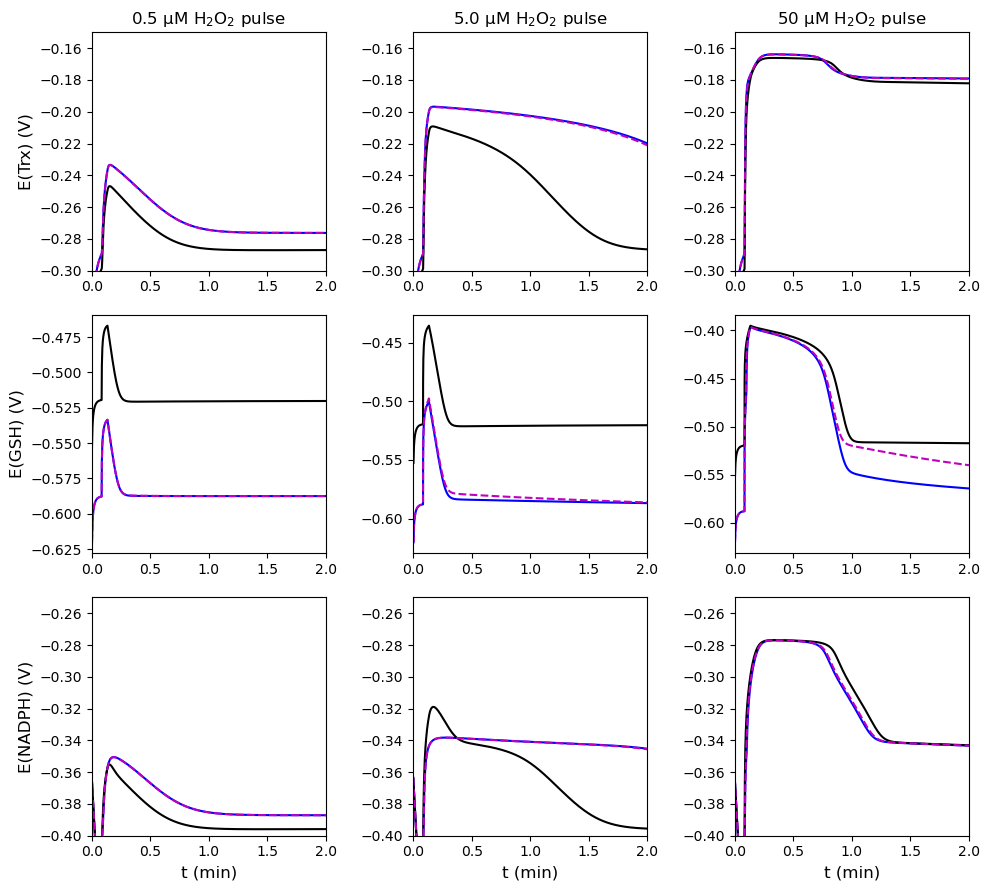

In [32]:
rows = 3
cols = 3
f, axarr = plt.subplots(rows,cols)
f.set_size_inches(w=cols*mpl_width_squarefig+1, h=rows*mpl_height_squarefig)

# 0.5 µM H2O2 pulse
ax = axarr.flat[0]
ax.plot(mod_A_05_H2O2_data["Time"]/60, mod_A_05_E_Trx, mod_A_line)
ax.plot(mod_B_05_H2O2_data["Time"]/60, mod_B_05_E_Trx, mod_B_line)
ax.plot(mod_A_dec_nohyp_05_H2O2_data["Time"]/60, mod_A_dec_nohyp_05_E_Trx,mod_A_dec_nohyp_line)
ax.set_xlim((0,2))
ax.set_ylabel(f'E(Trx) (V)', fontsize = mpl_ylabel_fontsize)
ax.set_ylim((-0.30,-0.15))
ax.set_title(f"0.5 {mu}M H$_2$O$_2$ pulse")

ax = axarr.flat[3]
ax.plot(mod_A_05_H2O2_data["Time"]/60, mod_A_05_E_GS, mod_A_line)
ax.plot(mod_B_05_H2O2_data["Time"]/60, mod_B_05_E_GS, mod_B_line)
ax.plot(mod_A_dec_nohyp_05_H2O2_data["Time"]/60, mod_A_dec_nohyp_05_E_GS,mod_A_dec_nohyp_line)
ax.set_ylabel(f'E(GSH) (V)', fontsize = mpl_ylabel_fontsize)
ax.set_xlim((0,2))
# ax.set_ylim((-0.44,-0.20))

ax = axarr.flat[6]
ax.plot(mod_A_05_H2O2_data["Time"]/60, mod_A_05_E_NADPHfree, mod_A_line)
ax.plot(mod_B_05_H2O2_data["Time"]/60, mod_B_05_E_NADPHfree, mod_B_line)
ax.plot(mod_A_dec_nohyp_05_H2O2_data["Time"]/60, mod_A_dec_nohyp_05_E_NADPHfree,mod_A_dec_nohyp_line)
ax.set_ylabel(f"E(NADPH) (V)", fontsize = mpl_ylabel_fontsize)
ax.set_xlabel(f't (min)', fontsize = mpl_xlabel_fontsize)
ax.set_xlim((0,2))
ax.set_ylim((-0.40,-0.25))

# 5 µM H2O2 pulse
ax = axarr.flat[1]
ax.plot(mod_A_5_H2O2_data["Time"]/60, mod_A_5_E_Trx, mod_A_line)
ax.plot(mod_B_5_H2O2_data["Time"]/60, mod_B_5_E_Trx, mod_B_line)
ax.plot(mod_A_dec_nohyp_5_H2O2_data["Time"]/60, mod_A_dec_nohyp_5_E_Trx,mod_A_dec_nohyp_line)
ax.set_xlim((0,2))
ax.set_ylim((-0.30,-0.15))
ax.set_title(f"5.0 {mu}M H$_2$O$_2$ pulse")

ax = axarr.flat[4]
ax.plot(mod_A_5_H2O2_data["Time"]/60, mod_A_5_E_GS, mod_A_line)
ax.plot(mod_B_5_H2O2_data["Time"]/60, mod_B_5_E_GS, mod_B_line)
ax.plot(mod_A_dec_nohyp_5_H2O2_data["Time"]/60, mod_A_dec_nohyp_5_E_GS,mod_A_dec_nohyp_line)
ax.set_xlim((0,2))
# ax.set_ylim((-0.44,-0.20))

ax = axarr.flat[7]
ax.plot(mod_A_5_H2O2_data["Time"]/60, mod_A_5_E_NADPHfree, mod_A_line)
ax.plot(mod_B_5_H2O2_data["Time"]/60, mod_B_5_E_NADPHfree, mod_B_line)
ax.plot(mod_A_dec_nohyp_5_H2O2_data["Time"]/60, mod_A_dec_nohyp_5_E_NADPHfree,mod_A_dec_nohyp_line)
ax.set_xlabel(f't (min)', fontsize = mpl_xlabel_fontsize)
ax.set_xlim((0,2))
ax.set_ylim((-0.40,-0.25))

# 50 µM H2O2 pulse
ax = axarr.flat[2]
ax.plot(mod_A_50_H2O2_data["Time"]/60, mod_A_50_E_Trx, mod_A_line)
ax.plot(mod_B_50_H2O2_data["Time"]/60, mod_B_50_E_Trx, mod_B_line)
ax.plot(mod_A_dec_nohyp_50_H2O2_data["Time"]/60, mod_A_dec_nohyp_50_E_Trx,mod_A_dec_nohyp_line)
ax.set_xlim((0,2))
ax.set_ylim((-0.30,-0.15))
ax.set_title(f"50 {mu}M H$_2$O$_2$ pulse")

ax = axarr.flat[5]
ax.plot(mod_A_50_H2O2_data["Time"]/60, mod_A_50_E_GS, mod_A_line)
ax.plot(mod_B_50_H2O2_data["Time"]/60, mod_B_50_E_GS, mod_B_line)
ax.plot(mod_A_dec_nohyp_50_H2O2_data["Time"]/60, mod_A_dec_nohyp_50_E_GS,mod_A_dec_nohyp_line)
ax.set_xlim((0,2))
# ax.set_ylim((-0.44,-0.20))

ax = axarr.flat[8]
ax.plot(mod_A_50_H2O2_data["Time"]/60, mod_A_50_E_NADPHfree, mod_A_line)
ax.plot(mod_B_50_H2O2_data["Time"]/60, mod_B_50_E_NADPHfree, mod_B_line)
ax.plot(mod_A_dec_nohyp_50_H2O2_data["Time"]/60, mod_A_dec_nohyp_50_E_NADPHfree,mod_A_dec_nohyp_line)
ax.set_xlabel(f't (min)', fontsize = mpl_xlabel_fontsize)
ax.set_xlim((0,2))
ax.set_ylim((-0.40,-0.25))

f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,"Benfig6.pdf"),dpi= mpl_dpi)


### Fig 7

Fig. 7. Responses of intracellular variables as a function of the amplitude of 3-s H 2 O 2 supply pulse. The correspondence of line to model is as for Fig. 4. Except for the yy axes
in (D) and (F), all plots are in logarithmic scale. (A) NADPH consumed owing to pulse, computed by integrating NADPH consumption from onset of the 3 s pulse to full
relaxation of all variables to within 1% of their prepulse steady-state value and subtracting the NADPH consumed over the same time period in the absence of a pulse. Note
the higher consumption by Design A. The lower consumption by Design C is due to a lower contribution of Prx2 for H 2 O 2 elimination, resulting in higher intracellular H 2 O 2
concentrations (B). (B, C, E, G) Maximum fold changes of the concentrations of intracellular H 2 O 2 , sulfenic Prx2, sulfinic Prx2, and disulfide Prx2, respectively. (D, F) Maximum
redox potential change of Trx and GSH, respectively. Note the larger dynamic ranges provided by Designs B and D in (B, C, E–G) and the low dynamic range provided by
Design C in (C, D, and G). The threshold effect in (E) ensues from the following. For a significant accumulation of Prx2 in sulfenic form to occur (E), the intracellular H 2 O 2
concentration must be high enough for its reaction with the sulfenic acid to compete with the condensation reaction. The amplitude of the extracellular H 2 O 2 concentration
pulse (Δ[eH 2 O 2 ]) causing a Δv sup pulse is given approximately by Δ[eH 2 O 2 ] 1⁄4 Δv sup /k p 1⁄4 Δv sup /(10.9 s  1 )

#### Published figure

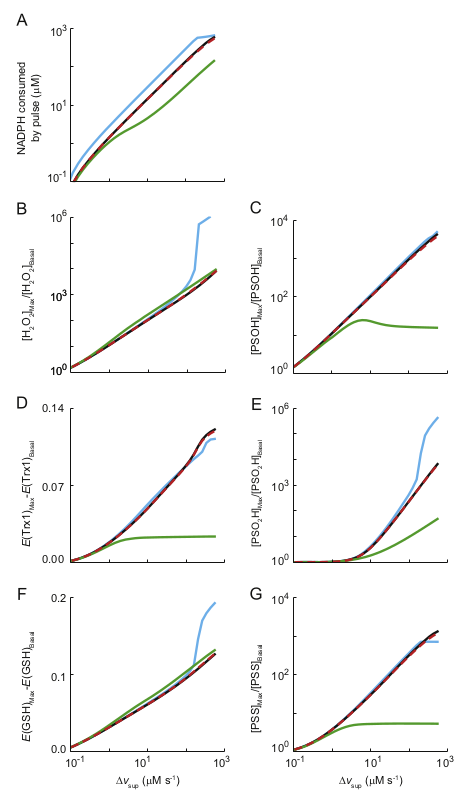

In [33]:
Image("Benfeitas 2014 fig7.png")

#### Data and sims

In [34]:
def do_BenFig7_sims(mod, v_sup, sim_idx, mod_idx, baseline_data, SS_data, end=3600,points=1000):
    """
    Performs the simulations for fig7 of Benfeitas 2014. 
    
    Requires 
    Several global arrays for data storage.
    """
    # Adjust model
    mod_eH2O2_pulse_conc_orig = getattr(mod,"exH2O2_pulse_conc")
    setattr(mod,"exH2O2_pulse_conc",v_sup/10.9)
    
    # Do simulation
    mod.doSim(end=end,points=points)
    mod_sim_data = mod.sim
    
    # Restore model
    setattr(mod,"exH2O2_pulse_conc",mod_eH2O2_pulse_conc_orig)

    # Grab data (arrays are defined as globals)
    mod_sim_NADPH_comsumption = mod_sim_data["Trx_red1"]+mod_sim_data["Trx_red2"]+mod_sim_data["GSR"]
    mod_baseline_NADPH_comsumption = baseline_data["Trx_red1"]+baseline_data["Trx_red2"]+baseline_data["GSR"]
    fig7A_data[sim_idx,mod_idx] = auc(mod_sim_data["Time"],mod_sim_NADPH_comsumption) - auc(baseline_data["Time"],mod_baseline_NADPH_comsumption)
    fig7B_data[sim_idx,mod_idx] = mod_sim_data["H2O2"].max()/SS_data["H2O2"]
    fig7C_data[sim_idx,mod_idx] = mod_sim_data["f_PSOH"].max()/baseline_data["f_PSOH"][-1]
    mod_r_Trx_ss = (SS_data["Trx1SH_Trx2SH"]+SS_data["Trx1SH_Trx2SOH"])/(SS_data["Trx1SOH_Trx2SH"]+SS_data["Trx1SOH_Trx2SOH"])
    fig7D_data[sim_idx,mod_idx] = nerst_vec(get_r_Trx(mod_sim_data),mod.E0_Trx).max() - nerst(mod_r_Trx_ss,mod.E0_Trx)
    fig7E_data[sim_idx,mod_idx] = mod_sim_data["f_PSO2H"].max()/baseline_data["f_PSO2H"][-1]
    mod_r_GS_ss = (SS_data["GSH"]**2)/SS_data["GSSG"]
    fig7F_data[sim_idx,mod_idx] = nerst_vec(get_r_GS(mod_sim_data),mod.E0_GSH).max() - nerst(mod_r_GS_ss,mod.E0_GSH)
    fig7G_data[sim_idx,mod_idx] = mod_sim_data["f_PSS"].max()/baseline_data["f_PSS"][-1]
    
def get_SS_data(mod,end=360000):
    """
    Generates baseline data. Several of the analyses in Benfeitas fig7 require baseline data for comparison.
    """
    mod.doSim(points=2,end=end)
    benfig7_SS_data = dict()
    for label in mod.sim.dtype.names:
        benfig7_SS_data[label] = mod.sim[label][-1]
            
    return benfig7_SS_data

In [35]:
# Adjust model to simulation conditions
setattr(mod_A,"do_exH2O2_pulse",True)
setattr(mod_B,"do_exH2O2_pulse",True)
setattr(mod_A_dec_nohyp,"do_exH2O2_pulse",True)

mod_A_exH2O2_pulse_conc_orig = getattr(mod_A,"exH2O2_pulse_conc")
mod_B_exH2O2_pulse_conc_orig = getattr(mod_B,"exH2O2_pulse_conc")
mod_A_dec_nohyp_exH2O2_pulse_conc_orig = getattr(mod_A_dec_nohyp,"exH2O2_pulse_conc")

mod_A_exH2O2_pulse_length_orig = getattr(mod_A,"exH2O2_pulse_length")
mod_B_exH2O2_pulse_length_orig = getattr(mod_B,"exH2O2_pulse_length")
mod_A_dec_nohyp_exH2O2_pulse_length_orig = getattr(mod_A_dec_nohyp,"exH2O2_pulse_length")

exH2O2_pulse_length = 3
setattr(mod_A,"exH2O2_pulse_length",exH2O2_pulse_length)
setattr(mod_B,"exH2O2_pulse_length",exH2O2_pulse_length)
setattr(mod_A_dec_nohyp,"exH2O2_pulse_length",exH2O2_pulse_length)

end = 7200
points = 1000

scan_range = np.logspace(-1,3,51)

# Data arrays 
fig7A_data = np.zeros((len(scan_range),4))
fig7B_data = np.zeros((len(scan_range),4))
fig7C_data = np.zeros((len(scan_range),4))
fig7D_data = np.zeros((len(scan_range),4))
fig7E_data = np.zeros((len(scan_range),4))
fig7F_data = np.zeros((len(scan_range),4))
fig7G_data = np.zeros((len(scan_range),4))

# General baselines
mod_A.doSim(end=end,points=points)
mod_A_baseline_data = mod_A.sim
mod_B.doSim(end=end,points=points)
mod_B_baseline_data = mod_B.sim
mod_A_dec_nohyp.doSim(end=end,points=points)
mod_A_dec_nohyp_baseline_data = mod_A_dec_nohyp.sim

mod_A_SS_data = get_SS_data(mod_A)
mod_B_SS_data = get_SS_data(mod_B)
mod_A_dec_nohyp_SS_data = get_SS_data(mod_A_dec_nohyp)

# Simulations 
for sim_idx,v_sup in enumerate(scan_range):
    print(f"v_sup: {v_sup}")
    # x data
    fig7A_data[sim_idx,0] = v_sup
    fig7B_data[sim_idx,0] = v_sup
    fig7C_data[sim_idx,0] = v_sup
    fig7D_data[sim_idx,0] = v_sup
    fig7E_data[sim_idx,0] = v_sup
    fig7F_data[sim_idx,0] = v_sup
    fig7G_data[sim_idx,0] = v_sup
    
    # Main simulations 
    do_BenFig7_sims(mod_A, v_sup, sim_idx, 1,mod_A_baseline_data,mod_A_SS_data,end=end,points=points)
    do_BenFig7_sims(mod_B, v_sup, sim_idx, 2,mod_B_baseline_data,mod_B_SS_data,end=end,points=points)
    do_BenFig7_sims(mod_A_dec_nohyp, v_sup, sim_idx, 3,mod_A_dec_nohyp_baseline_data,mod_A_dec_nohyp_SS_data,end=end,points=points)

# Restore models
setattr(mod_A,"do_exH2O2_pulse",False)
setattr(mod_B,"do_exH2O2_pulse",False)
setattr(mod_A_dec_nohyp,"do_exH2O2_pulse",False)

setattr(mod_A,"exH2O2_pulse_length",mod_A_exH2O2_pulse_length_orig)
setattr(mod_B,"exH2O2_pulse_length",mod_B_exH2O2_pulse_length_orig)
setattr(mod_A_dec_nohyp,"exH2O2_pulse_length",mod_A_dec_nohyp_exH2O2_pulse_length_orig)

setattr(mod_A,"exH2O2_pulse_conc",mod_A_exH2O2_pulse_conc_orig)
setattr(mod_B,"exH2O2_pulse_conc",mod_B_exH2O2_pulse_conc_orig)
setattr(mod_A_dec_nohyp,"exH2O2_pulse_conc",mod_A_dec_nohyp_exH2O2_pulse_conc_orig)


event eH2O2pulse_start is evaluating at 0.0

event eH2O2pulse_end is evaluating at 3.0383029700989805
event eH2O2pulse_start is assigning at 5.048905182883798 (delay=5.0)
event eH2O2pulse_end is assigning at 8.052244992641711 (delay=5.0)


AssignRules:29: RuntimeWarning: invalid value encountered in double_scalars
AssignRules:33: RuntimeWarning: divide by zero encountered in double_scalars
AssignRules:34: RuntimeWarning: invalid value encountered in double_scalars
<string>:1: RuntimeWarning: divide by zero encountered in divide
<string>:1: RuntimeWarning: invalid value encountered in divide
AssignRules:34: RuntimeWarning: divide by zero encountered in double_scalars
AssignRules:35: RuntimeWarning: invalid value encountered in double_scalars



event eH2O2pulse_start is evaluating at 0.0

event eH2O2pulse_end is evaluating at 3.019837245378912
event eH2O2pulse_start is assigning at 5.11564243309606 (delay=5.0)
event eH2O2pulse_end is assigning at 8.089395055729097 (delay=5.0)

event eH2O2pulse_start is evaluating at 0.0

event eH2O2pulse_end is evaluating at 3.012241318872702
event eH2O2pulse_start is assigning at 5.027649717890658 (delay=5.0)
event eH2O2pulse_end is assigning at 8.184078756002643 (delay=5.0)

event eH2O2pulse_start is evaluating at 0.0

event eH2O2pulse_end is evaluating at 3.0172020387892813
event eH2O2pulse_start is assigning at 5.119458792898944 (delay=5.0)
event eH2O2pulse_end is assigning at 8.180509549727594 (delay=5.0)

event eH2O2pulse_start is evaluating at 0.0

event eH2O2pulse_end is evaluating at 3.0410052645339594
event eH2O2pulse_start is assigning at 5.090370775843547 (delay=5.0)
event eH2O2pulse_end is assigning at 8.066119112731856 (delay=5.0)

event eH2O2pulse_start is evaluating at 0.0

e

/tmp/ipykernel_94435/2217131361.py:30: RuntimeWarning: divide by zero encountered in divide
  r_Trx = (data["Trx1SH_Trx2SH"]+data["Trx1SH_Trx2SOH"])/(data["Trx1SOH_Trx2SH"]+data["Trx1SOH_Trx2SOH"])
/tmp/ipykernel_94435/2217131361.py:23: RuntimeWarning: divide by zero encountered in divide
  r_GS = (data["GSH"]**2)/(data["GSSG"])



event eH2O2pulse_start is evaluating at 0.0

event eH2O2pulse_end is evaluating at 3.019837245378912
event eH2O2pulse_start is assigning at 5.11564243309606 (delay=5.0)
event eH2O2pulse_end is assigning at 8.041610729425596 (delay=5.0)

event eH2O2pulse_start is evaluating at 0.0

event eH2O2pulse_end is evaluating at 3.012241318872702
event eH2O2pulse_start is assigning at 5.027649717890658 (delay=5.0)
event eH2O2pulse_end is assigning at 8.041090957035449 (delay=5.0)
v_sup: 0.12022644346174129

event eH2O2pulse_start is evaluating at 0.0

event eH2O2pulse_end is evaluating at 3.0383029700989805
event eH2O2pulse_start is assigning at 5.048905182883798 (delay=5.0)
event eH2O2pulse_end is assigning at 8.039362820030016 (delay=5.0)

event eH2O2pulse_start is evaluating at 0.0

event eH2O2pulse_end is evaluating at 3.019837245378912
event eH2O2pulse_start is assigning at 5.11564243309606 (delay=5.0)
event eH2O2pulse_end is assigning at 8.089533986384057 (delay=5.0)

event eH2O2pulse_star

event eH2O2pulse_end is assigning at 8.080747675164798 (delay=5.0)

event eH2O2pulse_start is evaluating at 0.0

event eH2O2pulse_end is evaluating at 3.012241318872702
event eH2O2pulse_start is assigning at 5.027649717890658 (delay=5.0)
event eH2O2pulse_end is assigning at 8.060184310335357 (delay=5.0)
v_sup: 0.9120108393559097

event eH2O2pulse_start is evaluating at 0.0

event eH2O2pulse_end is evaluating at 3.0383029700989805
event eH2O2pulse_start is assigning at 5.048905182883798 (delay=5.0)
event eH2O2pulse_end is assigning at 8.040507204542042 (delay=5.0)

event eH2O2pulse_start is evaluating at 0.0

event eH2O2pulse_end is evaluating at 3.019837245378912
event eH2O2pulse_start is assigning at 5.11564243309606 (delay=5.0)
event eH2O2pulse_end is assigning at 8.041361129345809 (delay=5.0)

event eH2O2pulse_start is evaluating at 0.0

event eH2O2pulse_end is evaluating at 3.012241318872702
event eH2O2pulse_start is assigning at 5.027649717890658 (delay=5.0)
event eH2O2pulse_end i


event eH2O2pulse_start is evaluating at 0.0

event eH2O2pulse_end is evaluating at 3.012241318872702
event eH2O2pulse_start is assigning at 5.027649717890658 (delay=5.0)
event eH2O2pulse_end is assigning at 8.025207028172337 (delay=5.0)
v_sup: 6.918309709189366

event eH2O2pulse_start is evaluating at 0.0

event eH2O2pulse_end is evaluating at 3.0383029700989805
event eH2O2pulse_start is assigning at 5.048905182883798 (delay=5.0)
event eH2O2pulse_end is assigning at 8.043361050501622 (delay=5.0)

event eH2O2pulse_start is evaluating at 0.0

event eH2O2pulse_end is evaluating at 3.019837245378912
event eH2O2pulse_start is assigning at 5.11564243309606 (delay=5.0)
event eH2O2pulse_end is assigning at 8.04694444071126 (delay=5.0)

event eH2O2pulse_start is evaluating at 0.0

event eH2O2pulse_end is evaluating at 3.012241318872702
event eH2O2pulse_start is assigning at 5.027649717890658 (delay=5.0)
event eH2O2pulse_end is assigning at 8.060839291821084 (delay=5.0)
v_sup: 8.317637711026709

event eH2O2pulse_end is assigning at 8.043195478564417 (delay=5.0)
v_sup: 52.480746024977286

event eH2O2pulse_start is evaluating at 0.0

event eH2O2pulse_end is evaluating at 3.0383029700989805
event eH2O2pulse_start is assigning at 5.048905182883798 (delay=5.0)
event eH2O2pulse_end is assigning at 8.078528322324875 (delay=5.0)

event eH2O2pulse_start is evaluating at 0.0

event eH2O2pulse_end is evaluating at 3.019837245378912
event eH2O2pulse_start is assigning at 5.11564243309606 (delay=5.0)
event eH2O2pulse_end is assigning at 8.05215412869807 (delay=5.0)

event eH2O2pulse_start is evaluating at 0.0

event eH2O2pulse_end is evaluating at 3.012241318872702
event eH2O2pulse_start is assigning at 5.027649717890658 (delay=5.0)
event eH2O2pulse_end is assigning at 8.033571236101743 (delay=5.0)
v_sup: 63.095734448019364

event eH2O2pulse_start is evaluating at 0.0

event eH2O2pulse_end is evaluating at 3.0383029700989805
event eH2O2pulse_start is assigning at 5.048905182883798 (delay=5

v_sup: 398.1071705534973

event eH2O2pulse_start is evaluating at 0.0

event eH2O2pulse_end is evaluating at 3.0383029700989805
event eH2O2pulse_start is assigning at 5.048905182883798 (delay=5.0)
event eH2O2pulse_end is assigning at 8.046395107534826 (delay=5.0)

event eH2O2pulse_start is evaluating at 0.0

event eH2O2pulse_end is evaluating at 3.019837245378912
event eH2O2pulse_start is assigning at 5.11564243309606 (delay=5.0)
event eH2O2pulse_end is assigning at 8.031529939793161 (delay=5.0)

event eH2O2pulse_start is evaluating at 0.0

event eH2O2pulse_end is evaluating at 3.012241318872702
event eH2O2pulse_start is assigning at 5.027649717890658 (delay=5.0)
event eH2O2pulse_end is assigning at 8.015621895563479 (delay=5.0)
v_sup: 478.6300923226385

event eH2O2pulse_start is evaluating at 0.0

event eH2O2pulse_end is evaluating at 3.0383029700989805
event eH2O2pulse_start is assigning at 5.048905182883798 (delay=5.0)
event eH2O2pulse_end is assigning at 8.049396611967795 (delay=5.

#### Simulated Figure (figure S6 in our paper)

/tmp/ipykernel_94435/1301978065.py:67: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


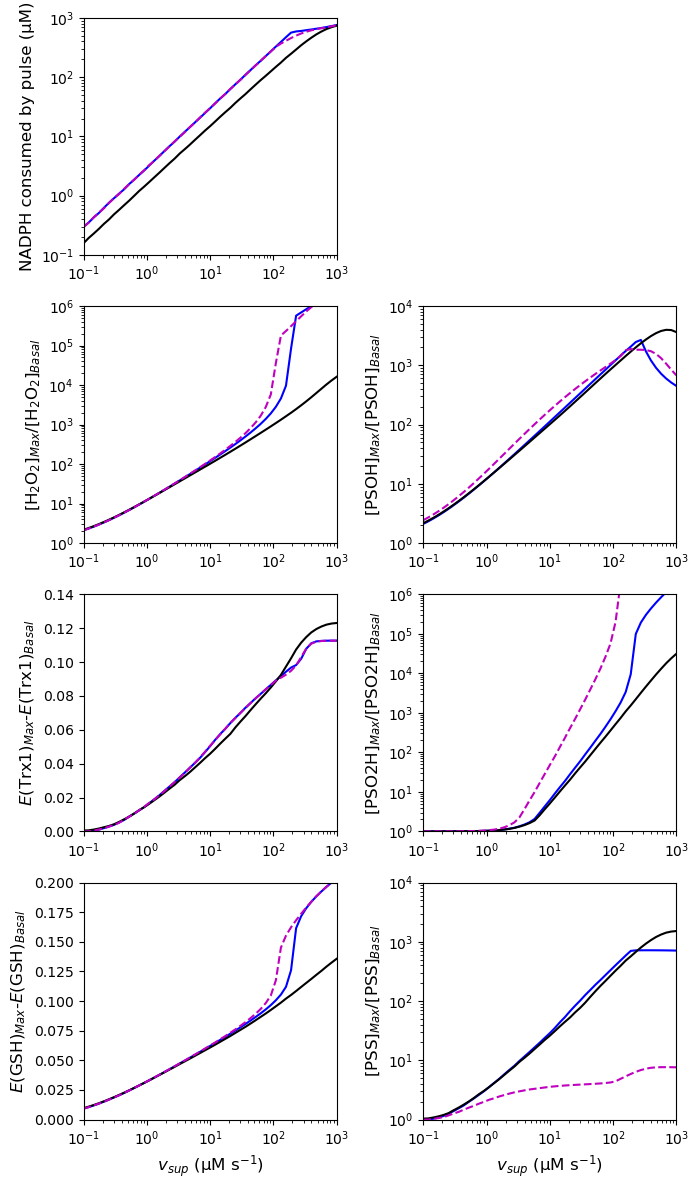

In [36]:
rows = 4
cols = 2
f, axarr = plt.subplots(rows,cols)
f.set_size_inches(w=cols*mpl_width_squarefig+1, h=rows*mpl_height_squarefig)

ax = axarr.flat[0]
ax.loglog(fig7A_data[:,0], fig7A_data[:,1], mod_A_line)
ax.loglog(fig7A_data[:,0], fig7A_data[:,2], mod_B_line)
ax.loglog(fig7A_data[:,0], fig7A_data[:,3], mod_A_dec_nohyp_line)
ax.set_ylabel(f'NADPH consumed by pulse ({mu}M)', fontsize = mpl_ylabel_fontsize)
ax.set_ylim((1e-1,1e3))
ax.set_xlim((1e-1,1e3))

f.delaxes(axarr.flat[1])

ax = axarr.flat[2]
ax.loglog(fig7B_data[:,0], fig7B_data[:,1], mod_A_line)
ax.loglog(fig7B_data[:,0], fig7B_data[:,2], mod_B_line)
ax.loglog(fig7B_data[:,0], fig7B_data[:,3], mod_A_dec_nohyp_line)
ax.set_ylabel('[H$_2$O$_2$]$_{Max}$/[H$_2$O$_2$]$_{Basal}$', fontsize = mpl_ylabel_fontsize)
ax.set_ylim((1e0,1e6))
ax.set_xlim((1e-1,1e3))

ax = axarr.flat[3]
ax.loglog(fig7C_data[:,0], fig7C_data[:,1], mod_A_line)
ax.loglog(fig7C_data[:,0], fig7C_data[:,2], mod_B_line)
ax.loglog(fig7C_data[:,0], fig7C_data[:,3], mod_A_dec_nohyp_line)
ax.set_ylabel("[PSOH]$_{Max}$/[PSOH]$_{Basal}$", fontsize = mpl_ylabel_fontsize)
ax.set_ylim((1e0,1e4))
ax.set_xlim((1e-1,1e3))

ax = axarr.flat[4]
ax.semilogx(fig7D_data[:,0], fig7D_data[:,1], mod_A_line)
ax.semilogx(fig7D_data[:,0], fig7D_data[:,2], mod_B_line)
ax.semilogx(fig7D_data[:,0], fig7D_data[:,3], mod_A_dec_nohyp_line)
ax.set_ylabel('$E$(Trx1)$_{Max}$-$E$(Trx1)$_{Basal}$', fontsize = mpl_ylabel_fontsize)
ax.set_ylim((0,0.14))
ax.set_xlim((1e-1,1e3))

ax = axarr.flat[5]
ax.loglog(fig7E_data[:,0], fig7E_data[:,1], mod_A_line)
ax.loglog(fig7E_data[:,0], fig7E_data[:,2], mod_B_line)
ax.loglog(fig7E_data[:,0], fig7E_data[:,3], mod_A_dec_nohyp_line)
ax.set_ylabel("[PSO2H]$_{Max}$/[PSO2H]$_{Basal}$", fontsize = mpl_ylabel_fontsize)
ax.set_ylim((1e0,1e6))
ax.set_xlim((1e-1,1e3))

ax = axarr.flat[6]
ax.semilogx(fig7F_data[:,0], fig7F_data[:,1], mod_A_line)
ax.semilogx(fig7F_data[:,0], fig7F_data[:,2], mod_B_line)
ax.semilogx(fig7F_data[:,0], fig7F_data[:,3], mod_A_dec_nohyp_line)
ax.set_ylabel('$E$(GSH)$_{Max}$-$E$(GSH)$_{Basal}$', fontsize = mpl_ylabel_fontsize)
ax.set_xlabel('$v$$_{sup}$ '+f'({mu}M'+' s$^{-1}$)', fontsize = mpl_xlabel_fontsize)
ax.set_ylim((0,0.2))
ax.set_xlim((1e-1,1e3))

ax = axarr.flat[7]
ax.loglog(fig7G_data[:,0], fig7G_data[:,1], mod_A_line)
ax.loglog(fig7G_data[:,0], fig7G_data[:,2], mod_B_line)
ax.loglog(fig7G_data[:,0], fig7G_data[:,3], mod_A_dec_nohyp_line)
ax.set_ylabel("[PSS]$_{Max}$/[PSS]$_{Basal}$", fontsize = mpl_ylabel_fontsize)
ax.set_xlabel('$v$$_{sup}$ '+f'({mu}M'+' s$^{-1}$)', fontsize = mpl_xlabel_fontsize)
ax.set_ylim((1e0,1e4))
ax.set_xlim((1e-1,1e3))

f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,"Benfig7.pdf"),dpi= mpl_dpi)
